### Import Library

Reference

* https://github.com/cure-lab/LTSF-Linear
* https://today-1.tistory.com/60

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Directory

In [3]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [4]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [5]:
df

Date       Date  call_interest_rate  government_bond_3yr  \
num                                                        
0    2006-01-15                3.74                 5.02   
1    2006-02-15                3.92                 4.87   
2    2006-03-15                3.97                 4.93   
3    2006-04-15                3.97                 4.95   
4    2006-05-15                3.96                 4.78   
..          ...                 ...                  ...   
217  2024-02-15                3.58                 3.35   
218  2024-03-15                3.47                 3.31   
219  2024-04-15                3.52                 3.44   
220  2024-05-15                3.53                 3.43   
221  2024-06-15                3.55                 3.26   

Date  deposit_bank_loan_rate_avg  KOSPI_index  KOSDAQ_index  NASDAQ_index  \
num                                                                         
0                           5.79  1379.323810    708.266190   2289.991504   
1                           5.76  1341.722000    656.840500   2273.666311   
2                           5.89  1331.720000    657.500000   2300.255668   
3                           5.83  1415.921000    693.712500   2338.677362   
4                           5.89  1388.834500    663.351000   2245.281816   
..                           ...          ...           ...           ...   
217                         4.85  2630.416316    845.114211  15808.935010   
218                         4.85  2699.587000    890.640000  16216.295508   
219                         4.77  2674.250000    861.700000  15950.863548   
220                         4.78  2710.446000    854.389500  16536.317161   
221                         4.71  2748.160526    854.670000  17495.891653   

Date   M2_Korea   M2_USA  broad_liquidity  ...  \
num                                        ...   
0     1027.2356   6730.3              8.7  ...   
1     1034.3588   6754.9              8.1  ...   
2     1038.7277   6769.5              8.5  ...   
3     1046.4002   6807.0              7.9  ...   
4     1056.9430   6813.9              8.8  ...   
..          ...      ...              ...  ...   
217   3929.8580  20761.8              4.6  ...   
218   3996.2166  20862.9              5.6  ...   
219   4013.2282  20881.1              4.6  ...   
220   4014.1308  20959.4              5.2  ...   
221   4037.5808  21020.1              5.5  ...   

Date  Sejong_apartment_sale_price_index  Gyeonggi_apartment_sale_price_index  \
num                                                                            
0                                  75.7                                 66.3   
1                                  77.0                                 67.2   
2                                  82.0                                 68.0   
3                                  77.4                                 68.9   
4                                  78.0                                 69.8   
..                                  ...                                  ...   
217                               128.0                                136.6   
218                               128.7                                136.6   
219                               127.9                                137.0   
220                               126.6                                137.1   
221                               127.8                                138.1   

Date  Gangwon_apartment_sale_price_index  Chungbuk_apartment_sale_price_index  \
num                                                                             
0                                   58.1                                 64.0   
1                                   58.4                                 65.2   
2                                   57.6                                 65.6   
3                                   58.2                                 66.5   
4                                   59.

In [6]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

### DLinear 

In [7]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len # window_size
        self.pred_len = configs.pred_len # forcast_size

        # Decompsition Kernel Size
        kernel_size = configs.ker_len
        self.decompsition = series_decomp(kernel_size) # kernel_size
        self.individual = configs.individual # False
        self.channels = configs.enc_in # feature_size

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

def time_slide_df(df, window_size, forecast_size, date, target, columns):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        if window_size > 0:
            # x: features from the past window_size (including columns)
            x = df_.loc[idx:idx+window_size-1, columns].values # Convert to a multidimensional array.
        else:
            # if you already use past variables, you may not need window_size
            # x: Use only the current time point
            x = df_.iloc[idx][columns].values.reshape(1, -1)
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def predict(model, data_loader, data_date, std, mean):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    targets = []
    dates = []
    with torch.no_grad():  # No need to track the gradients
        for data, target, date in zip(data_loader.dataset.X, data_loader.dataset.Y, data_date):
            data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add Batch dimension
            output = model(data).cpu().numpy().flatten()
            predictions.append(output)
            targets.append(torch.tensor(target, dtype=torch.float32).numpy().flatten())
            dates.append(date)  # save date
    
    predictions = np.array(predictions).flatten() * std + mean
    targets = np.array(targets).flatten() * std + mean
    
    dates = np.array(dates).flatten()
    # Remove Duplicate Dates
    unique_dates, indices = np.unique(dates, return_index=True)
    predictions = np.array(predictions).flatten()[indices]
    targets = np.array(targets).flatten()[indices]
    
    return unique_dates, predictions, targets

### Common Experiment Setting

In [20]:
batch_size = 16
kernel_size = 25 

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [73]:
### Experiment Setting
version = "V1"
window_size = 3
forecast_size= 3 
epoch = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", 
                  "residential_building_start_status"] + [nf.columns[0]] # exampel: Column defined before & Target
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=True,
    enc_in= len(columns_to_use) # feature_size
)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

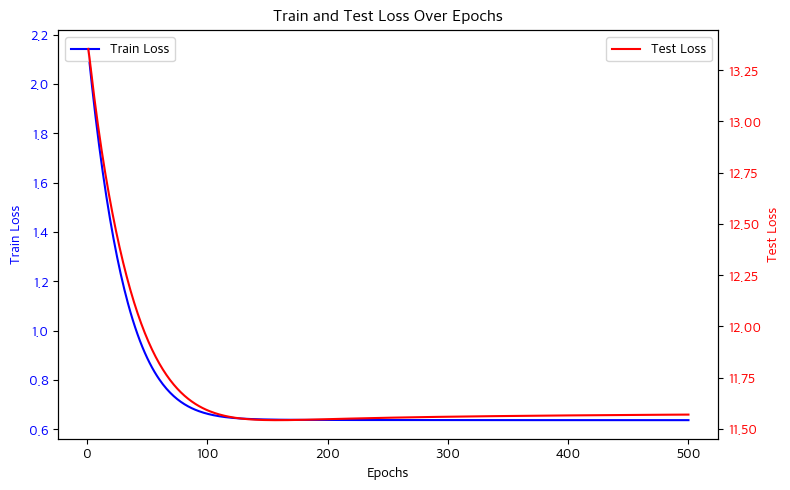

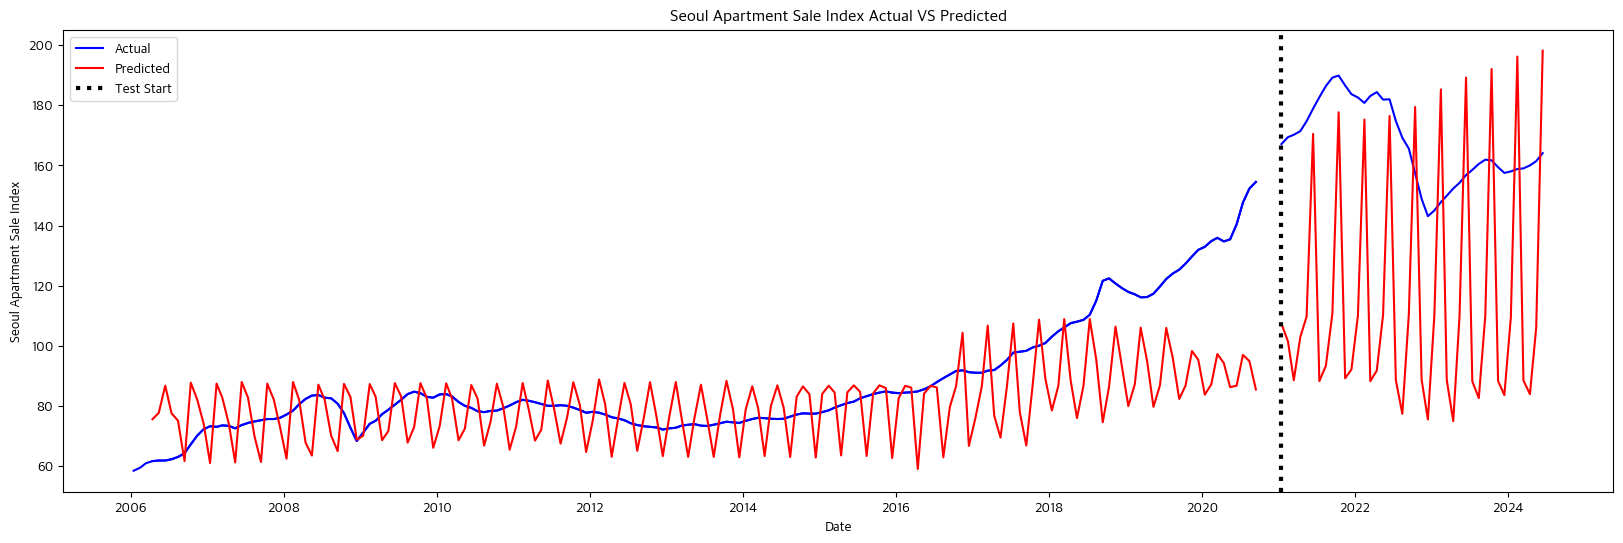

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

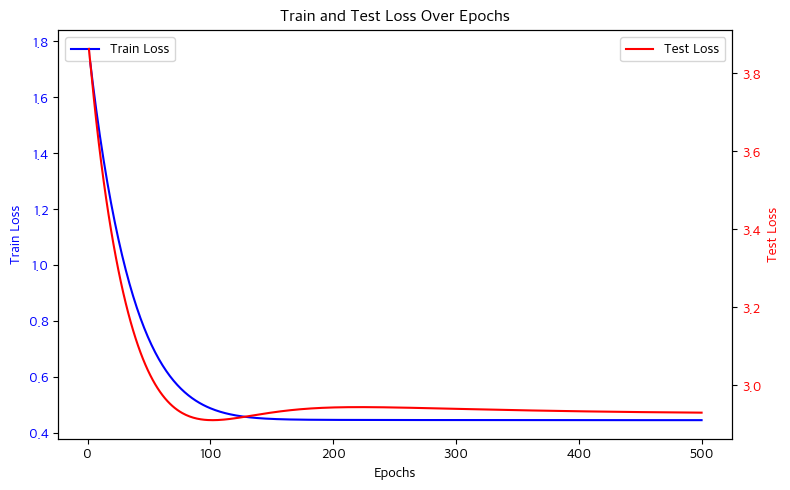

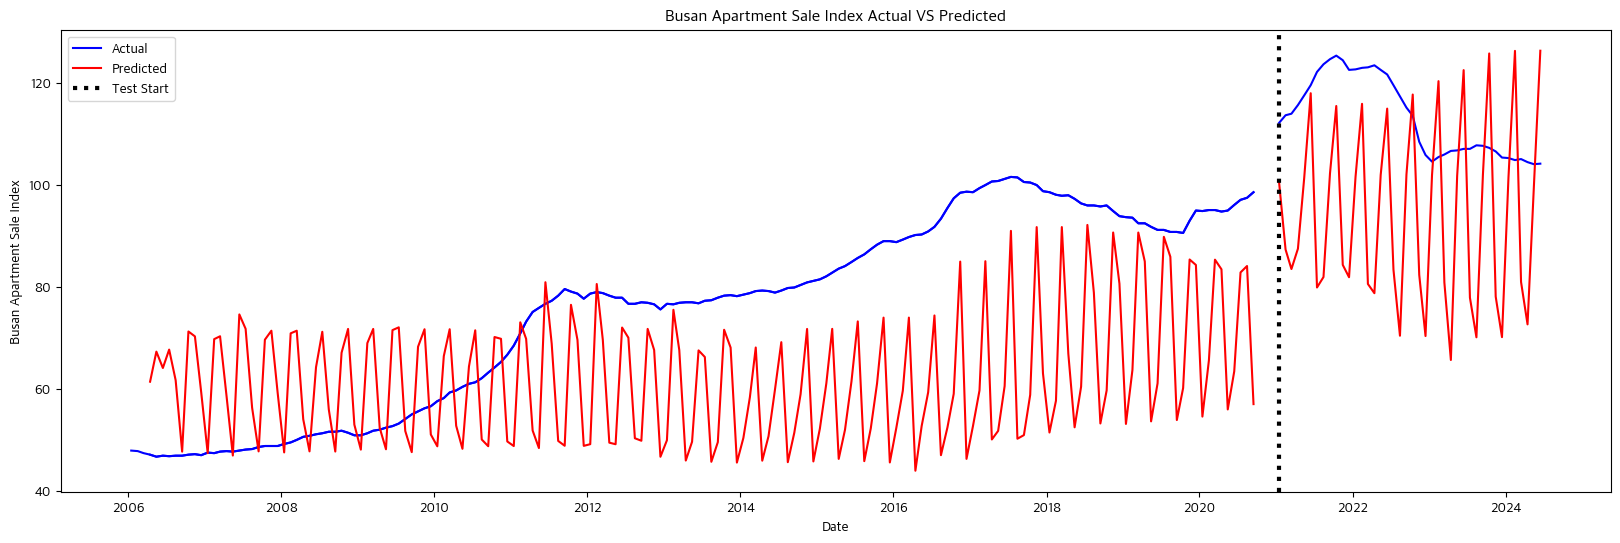

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

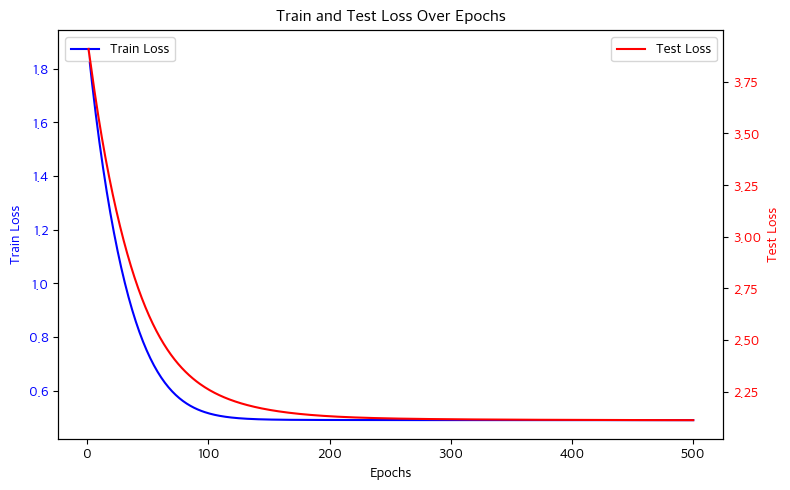

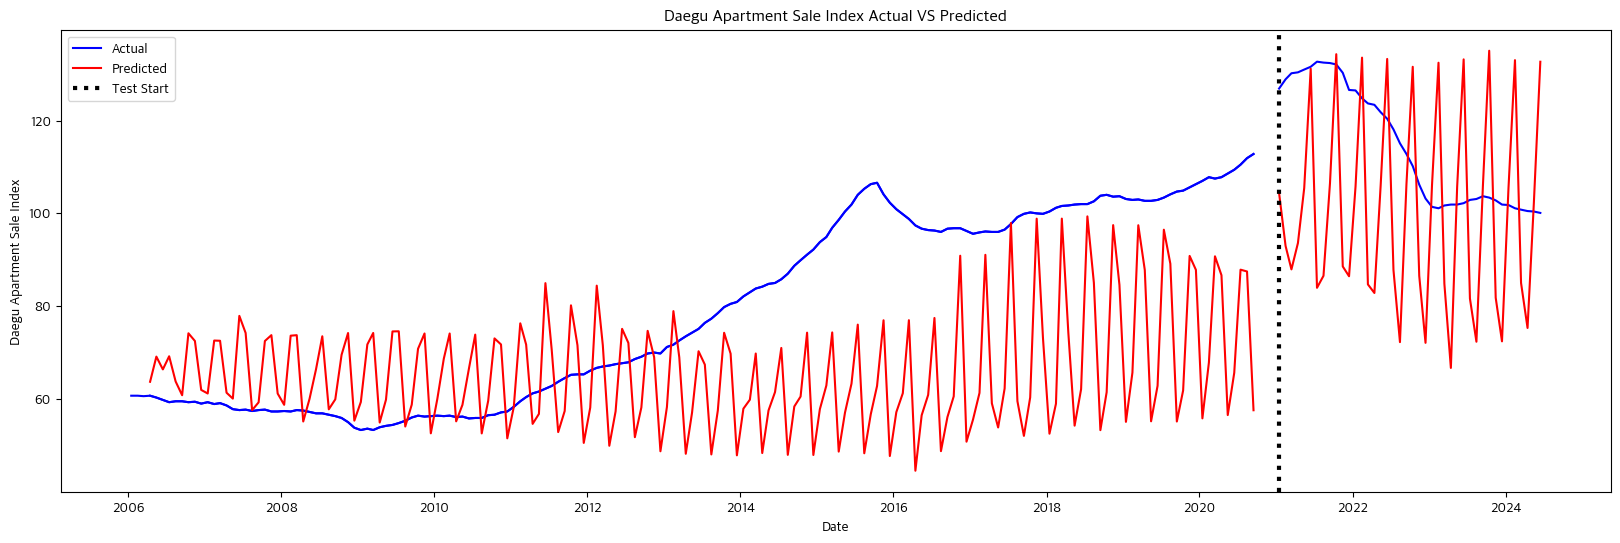

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

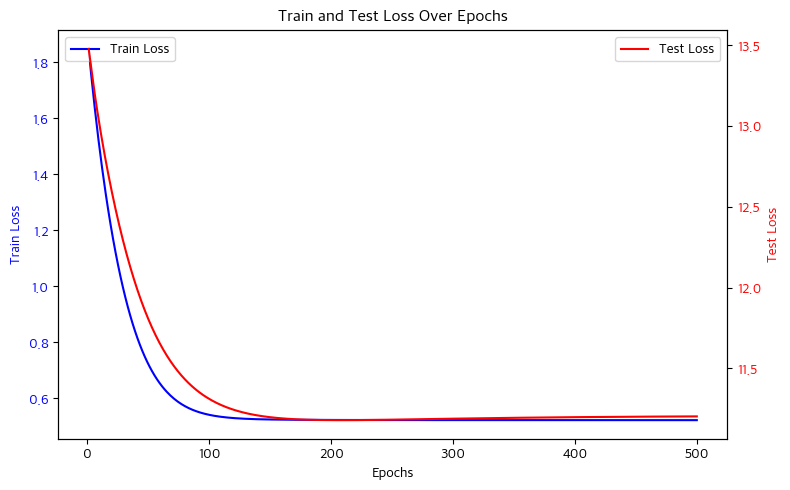

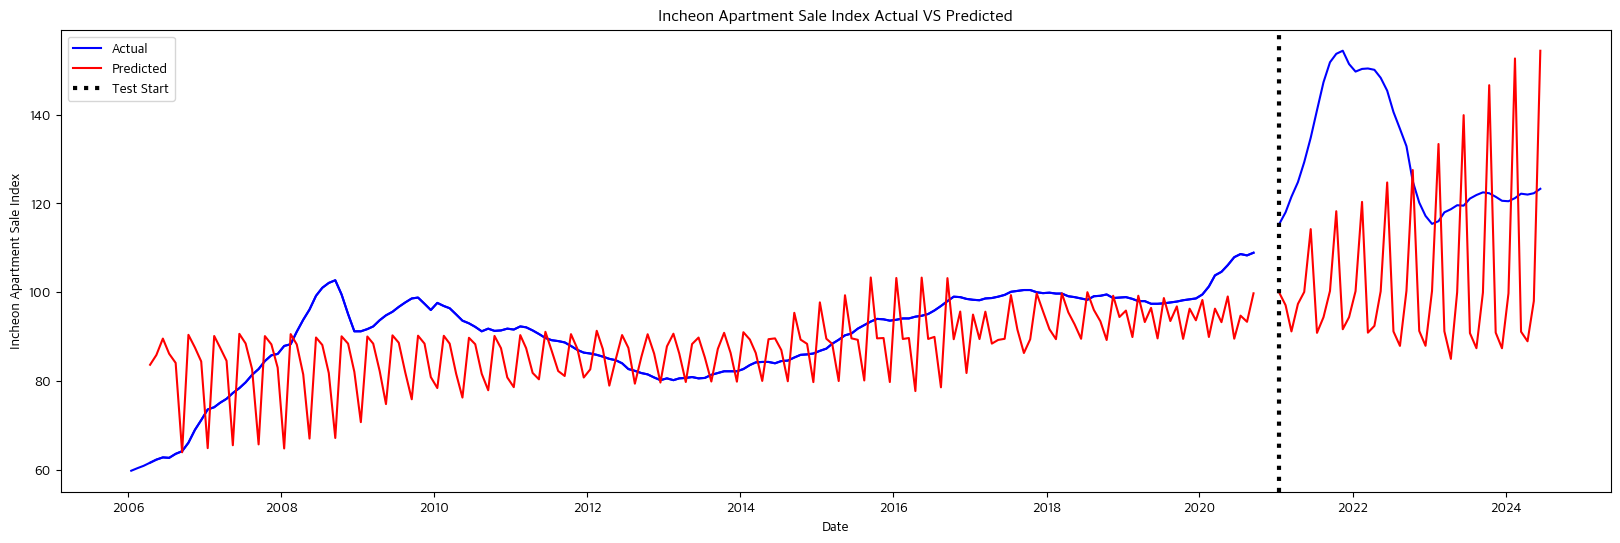

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

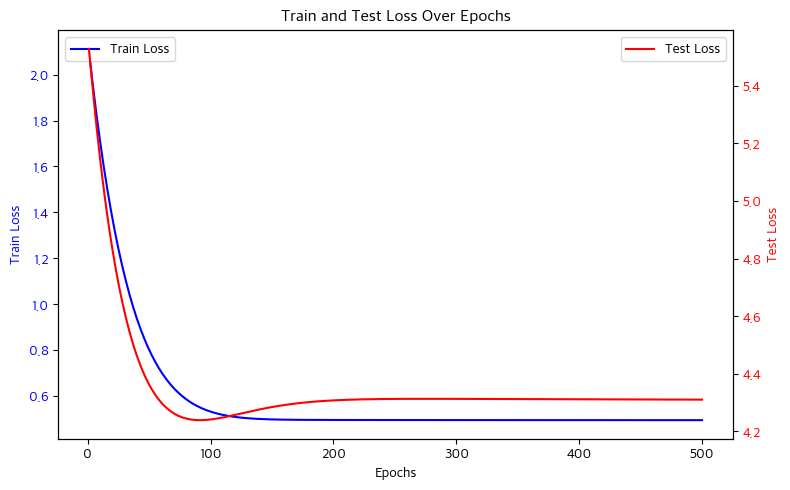

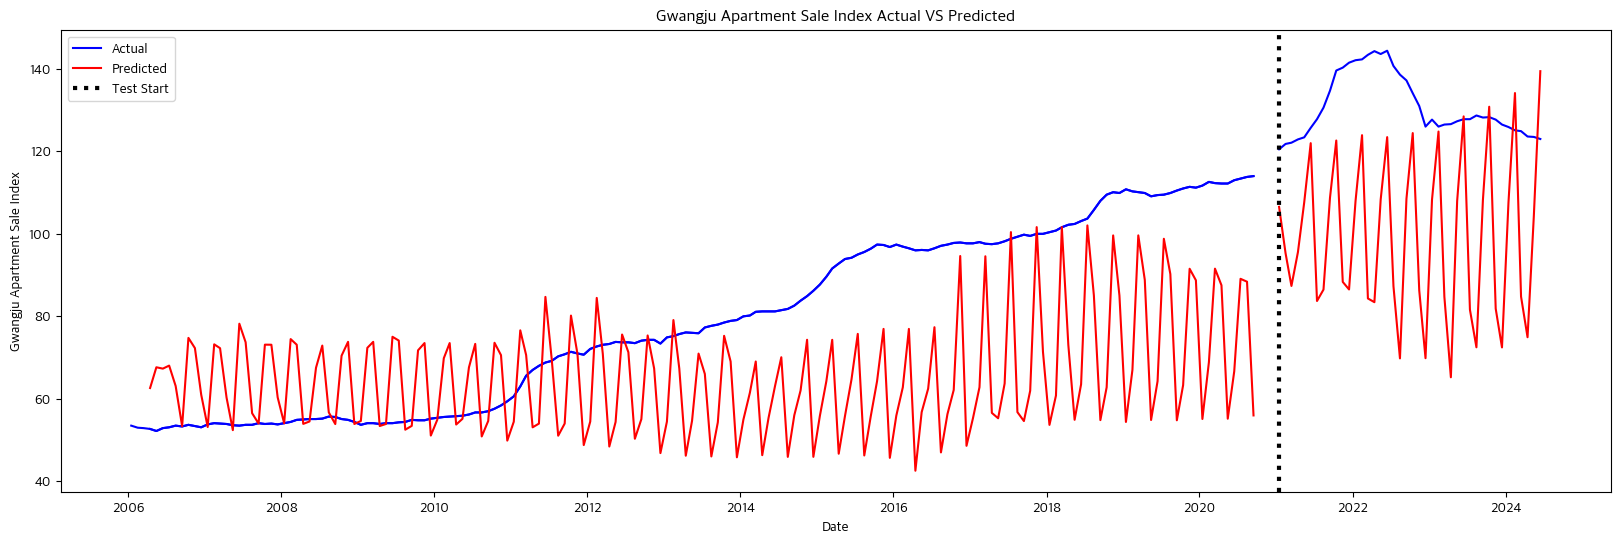

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

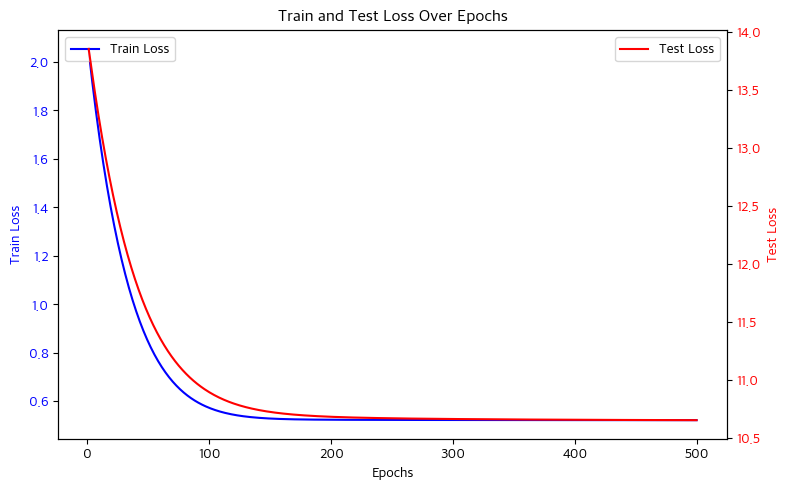

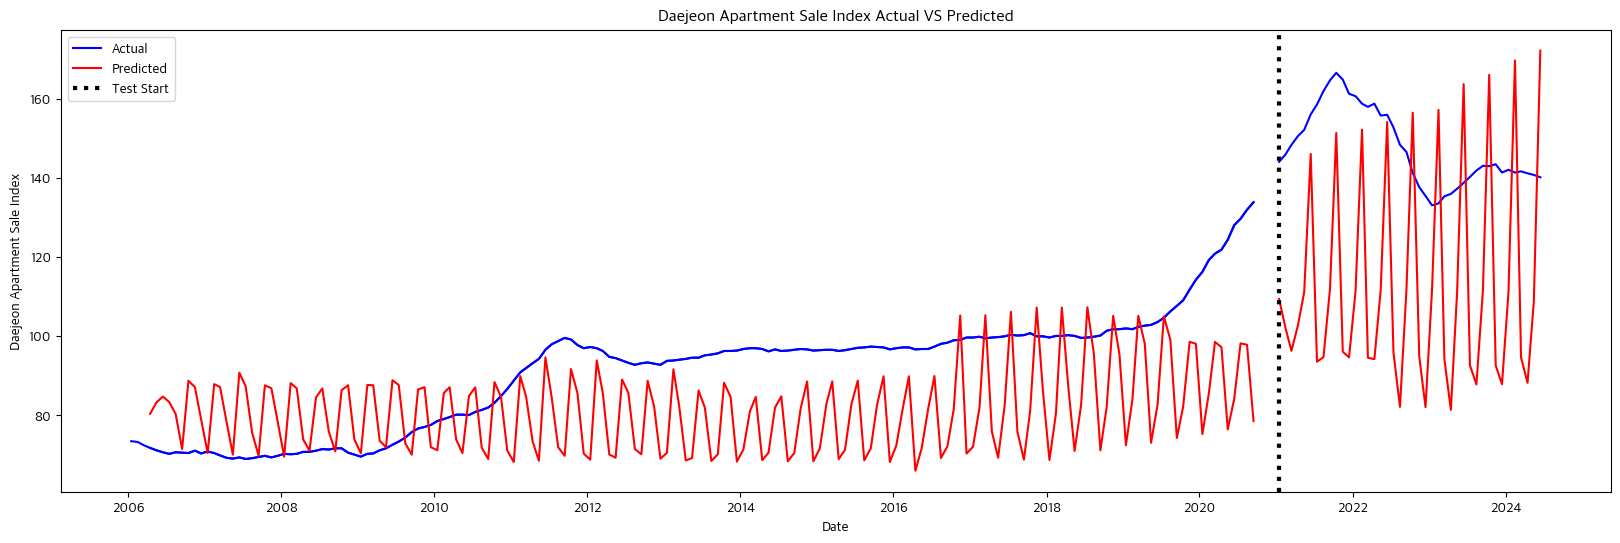

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

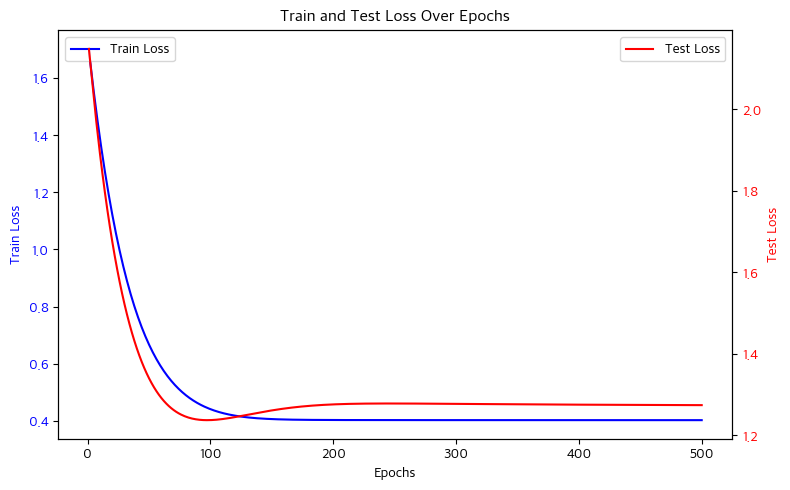

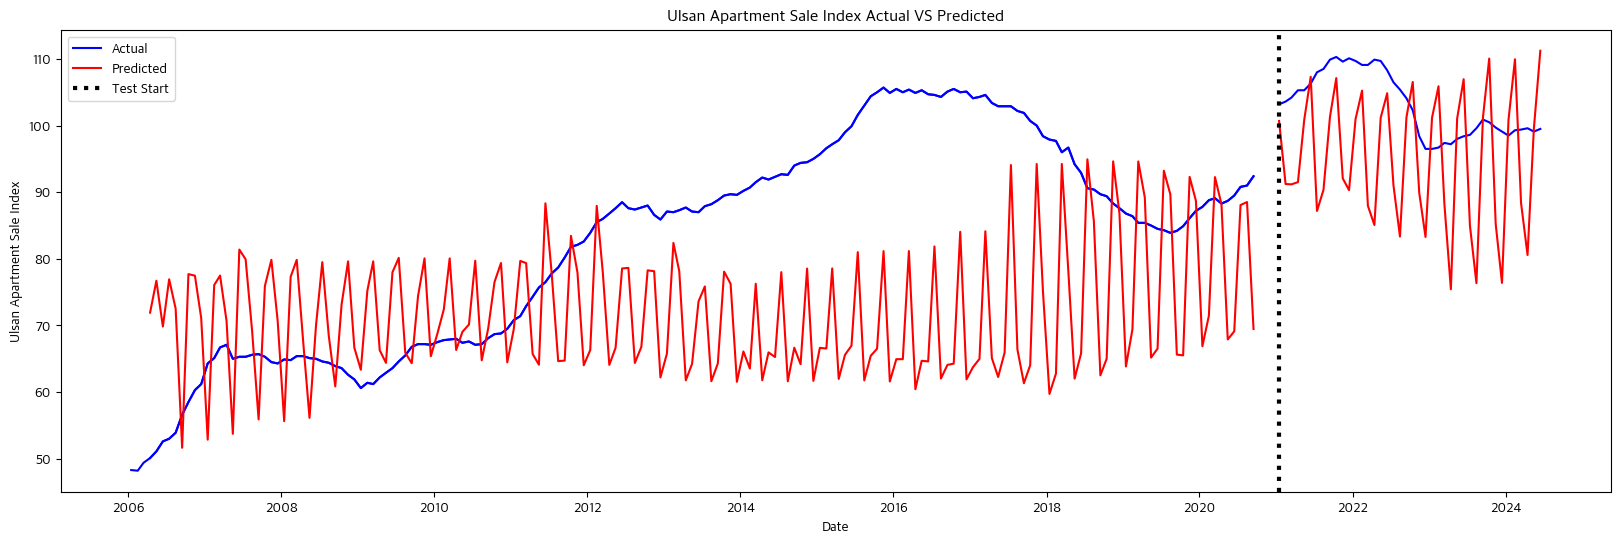

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

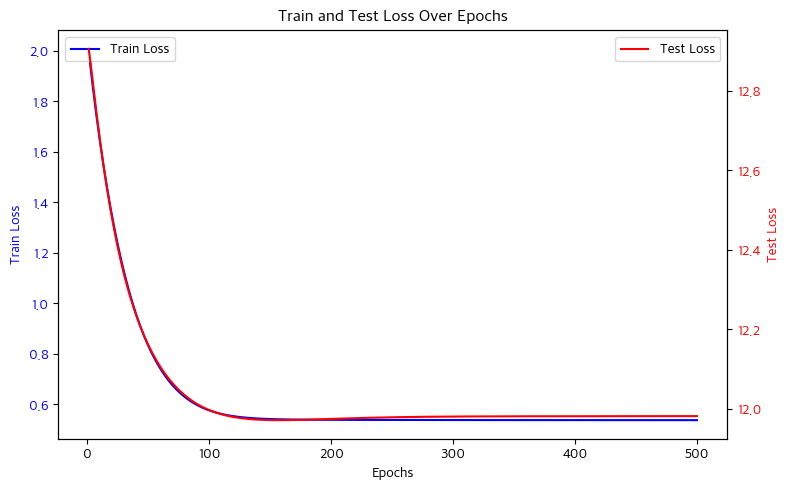

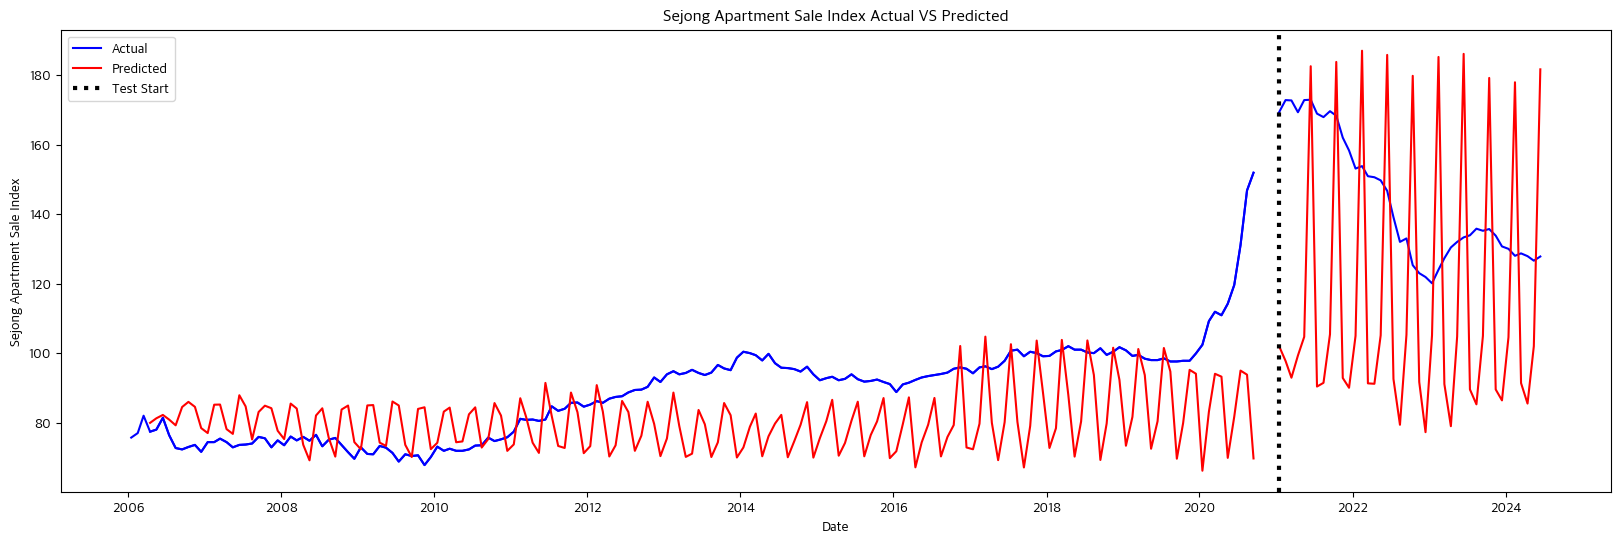

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

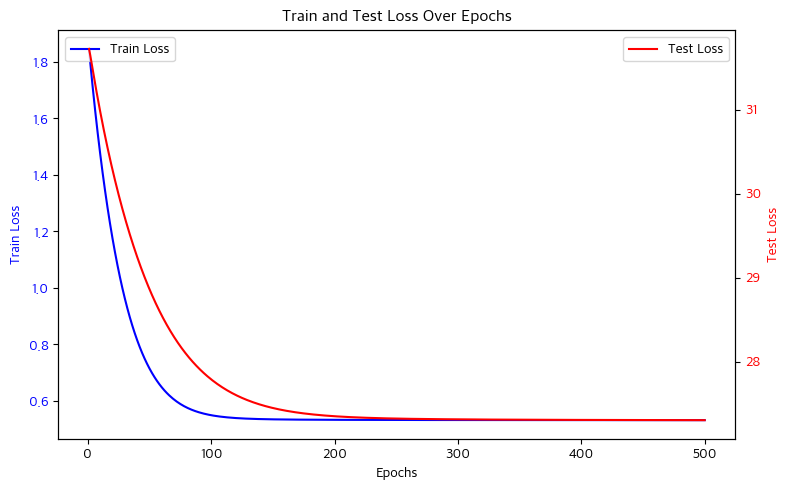

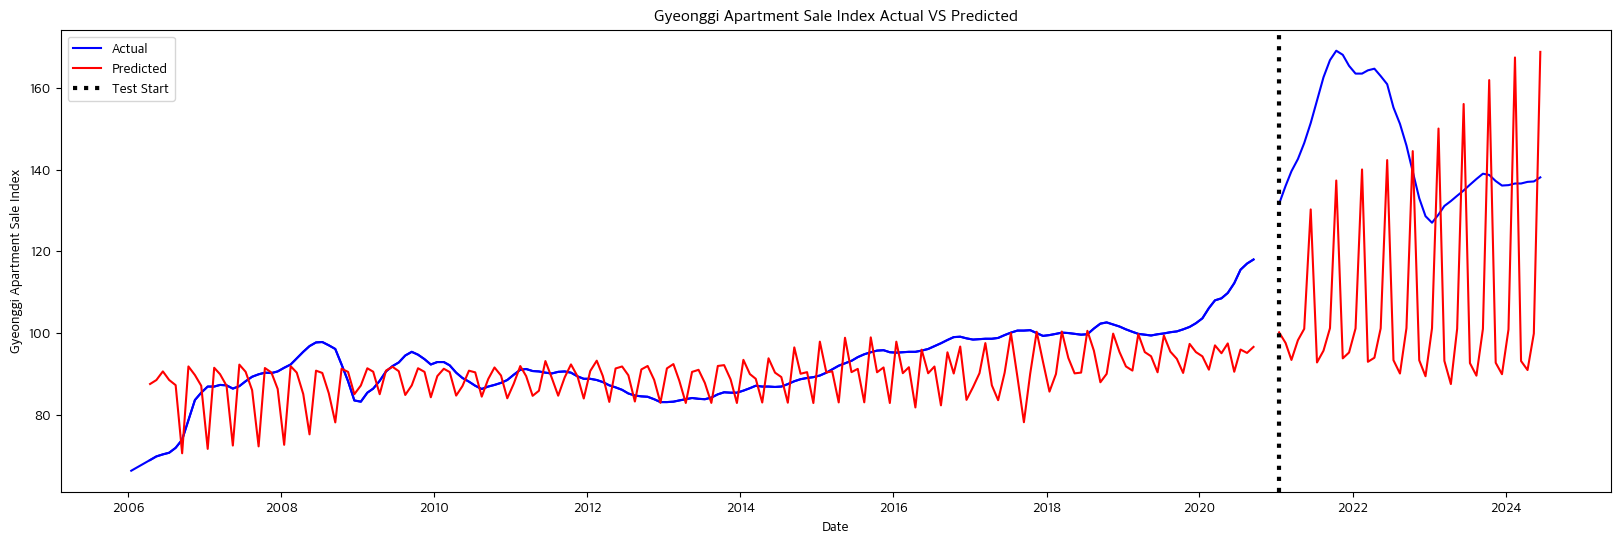

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

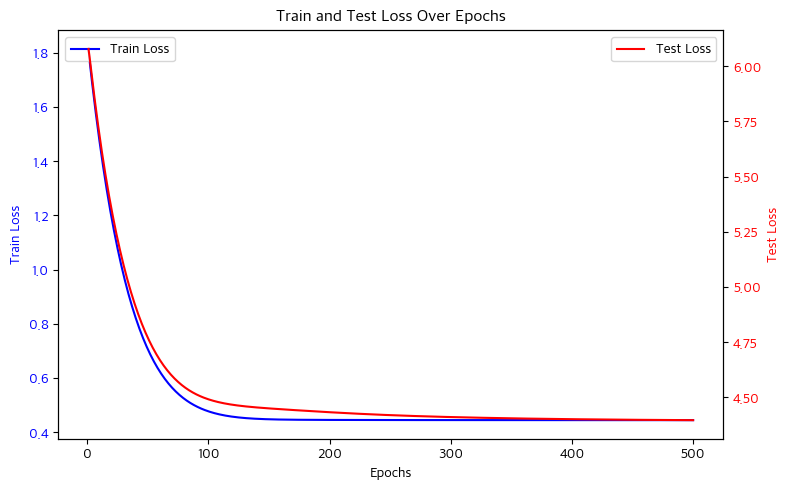

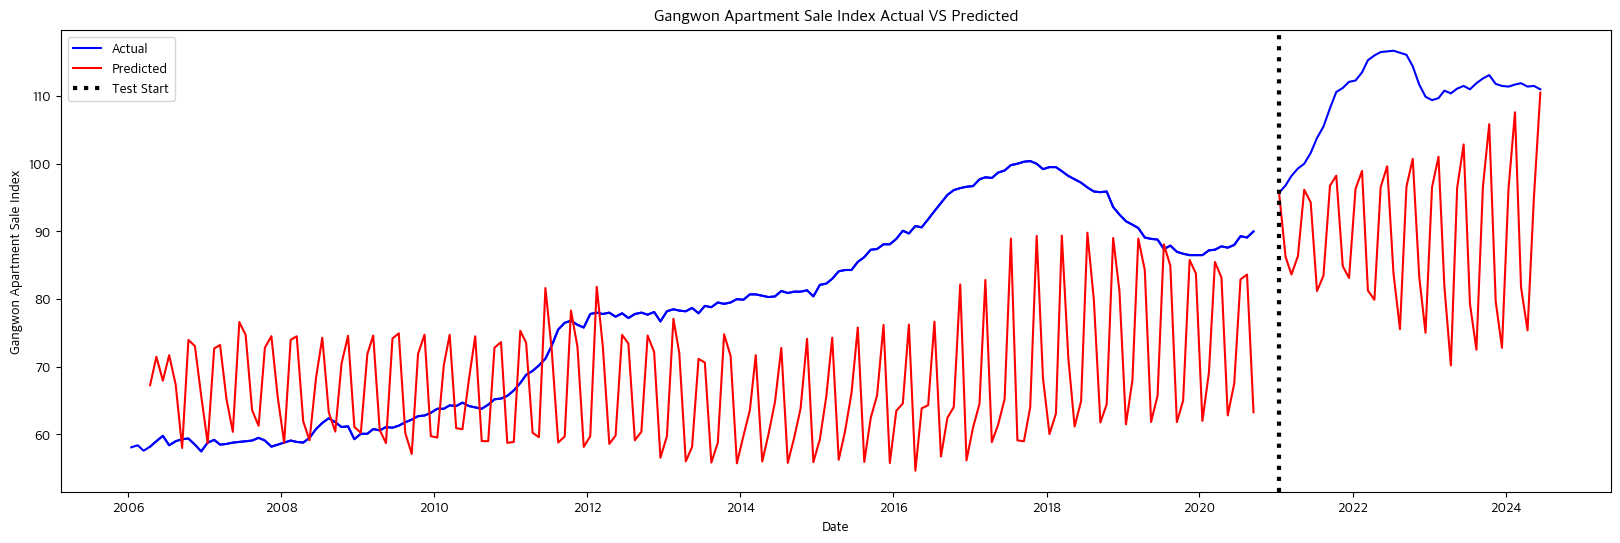

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

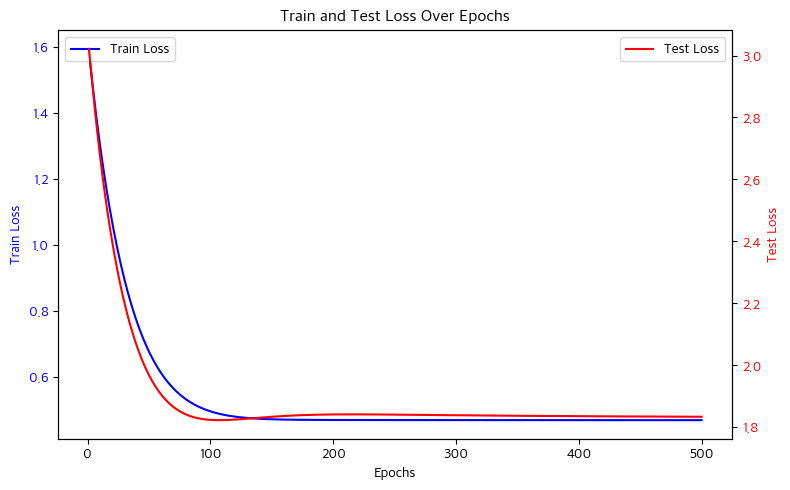

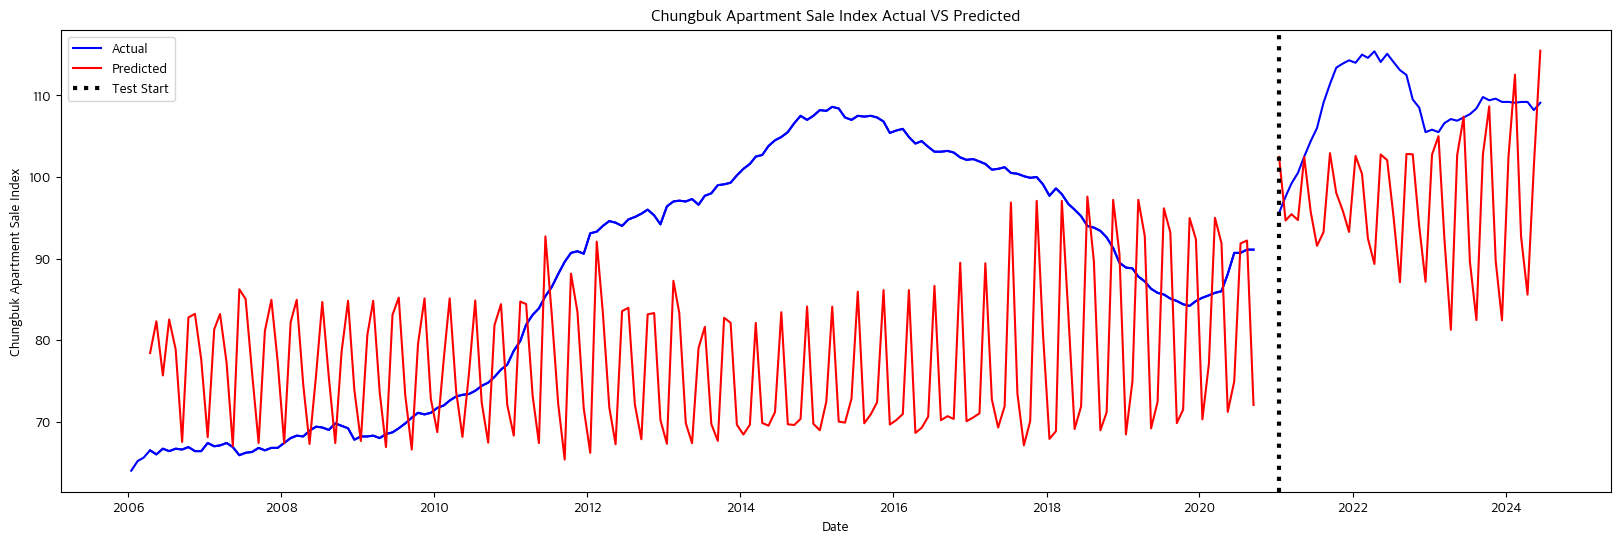

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

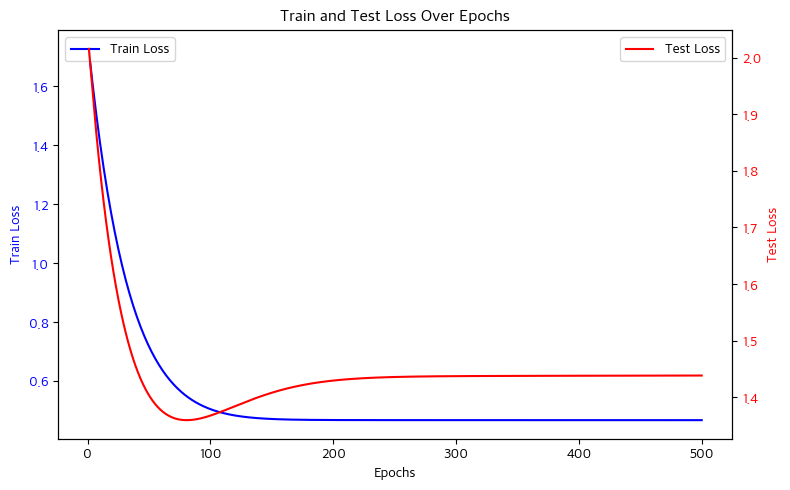

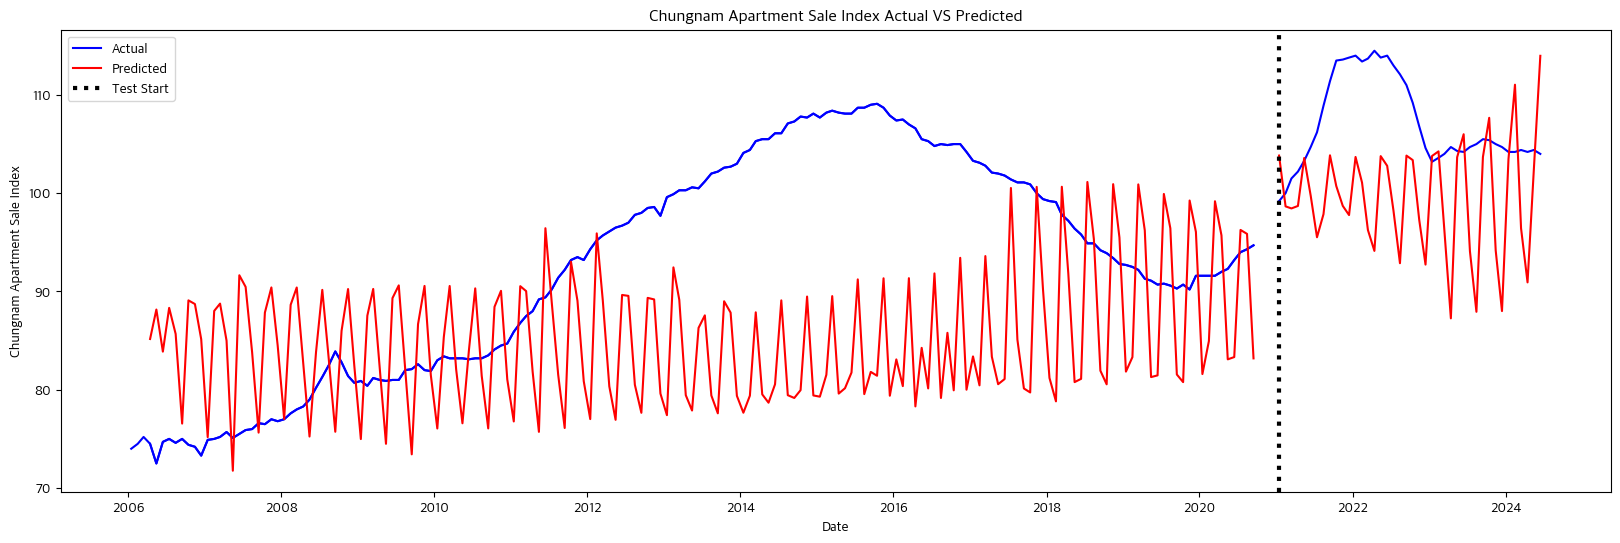

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

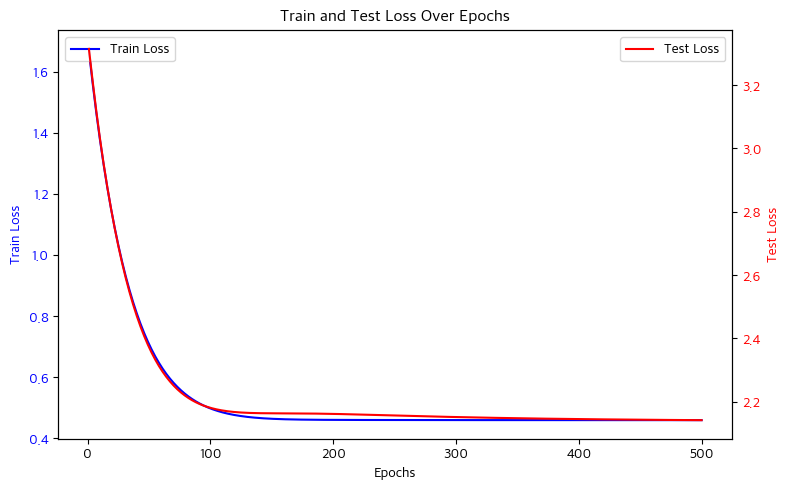

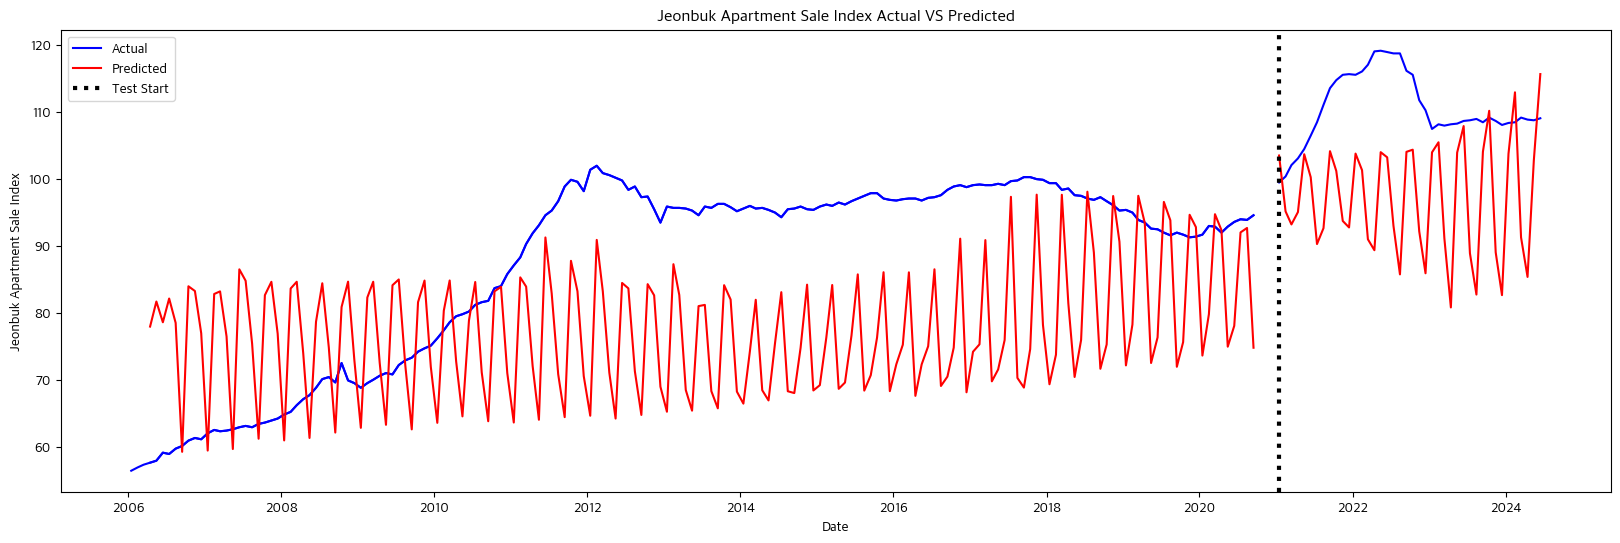

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

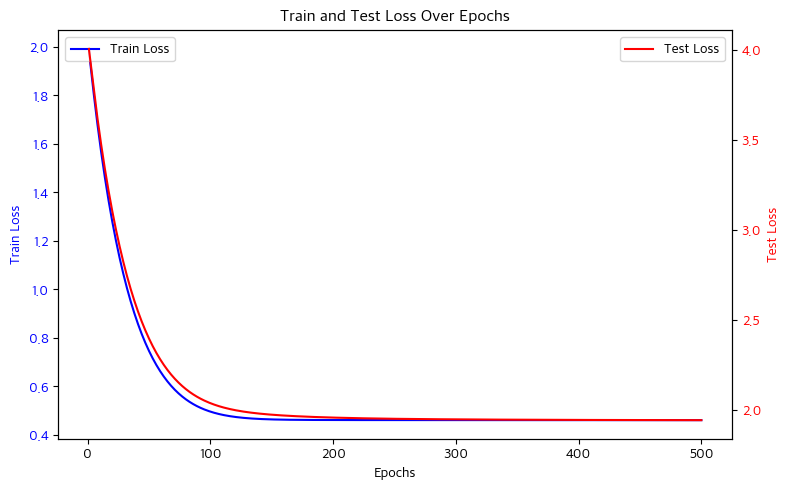

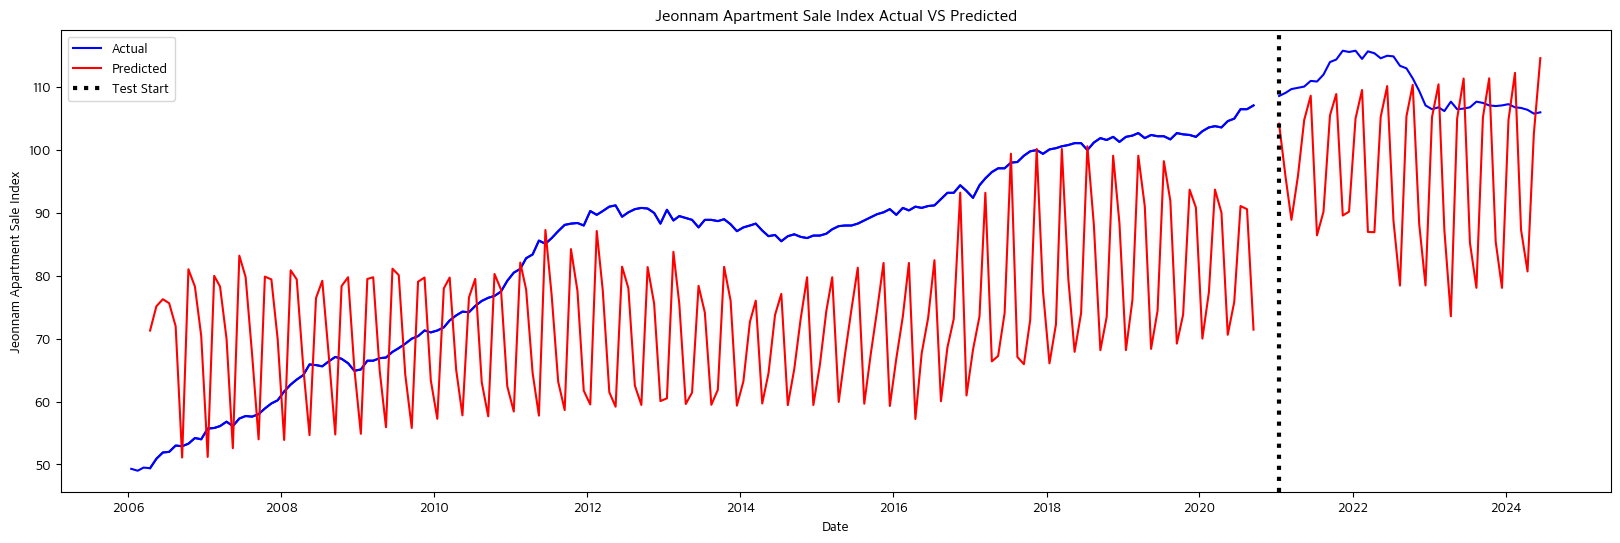

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

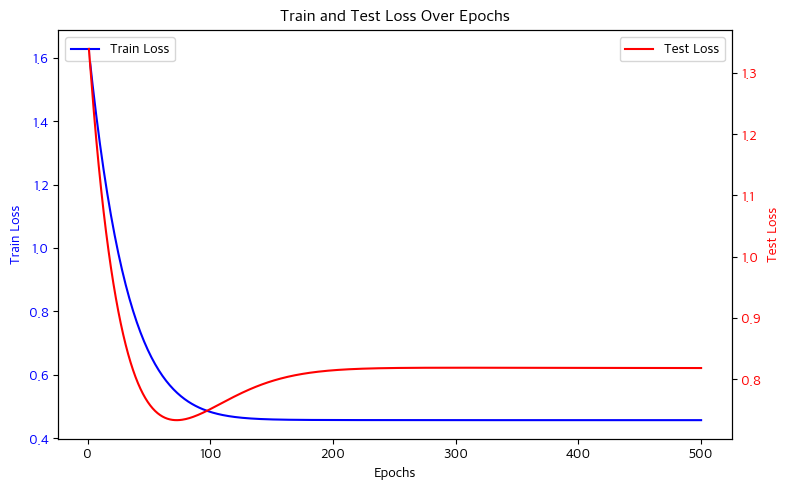

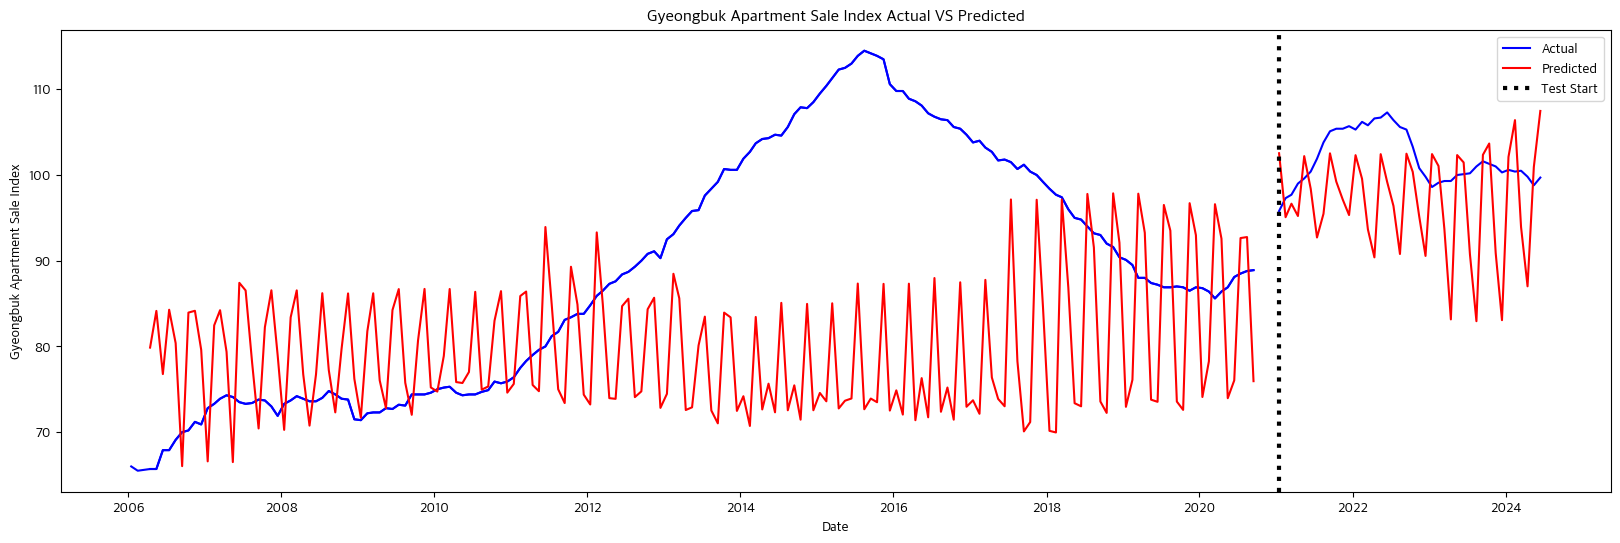

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

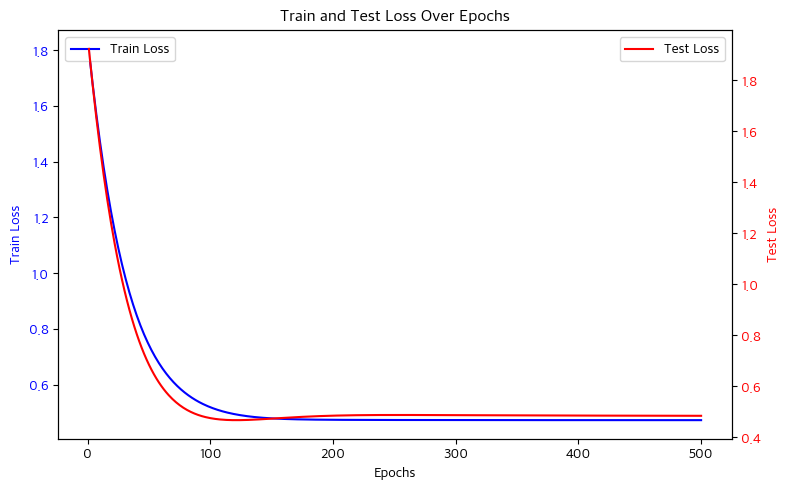

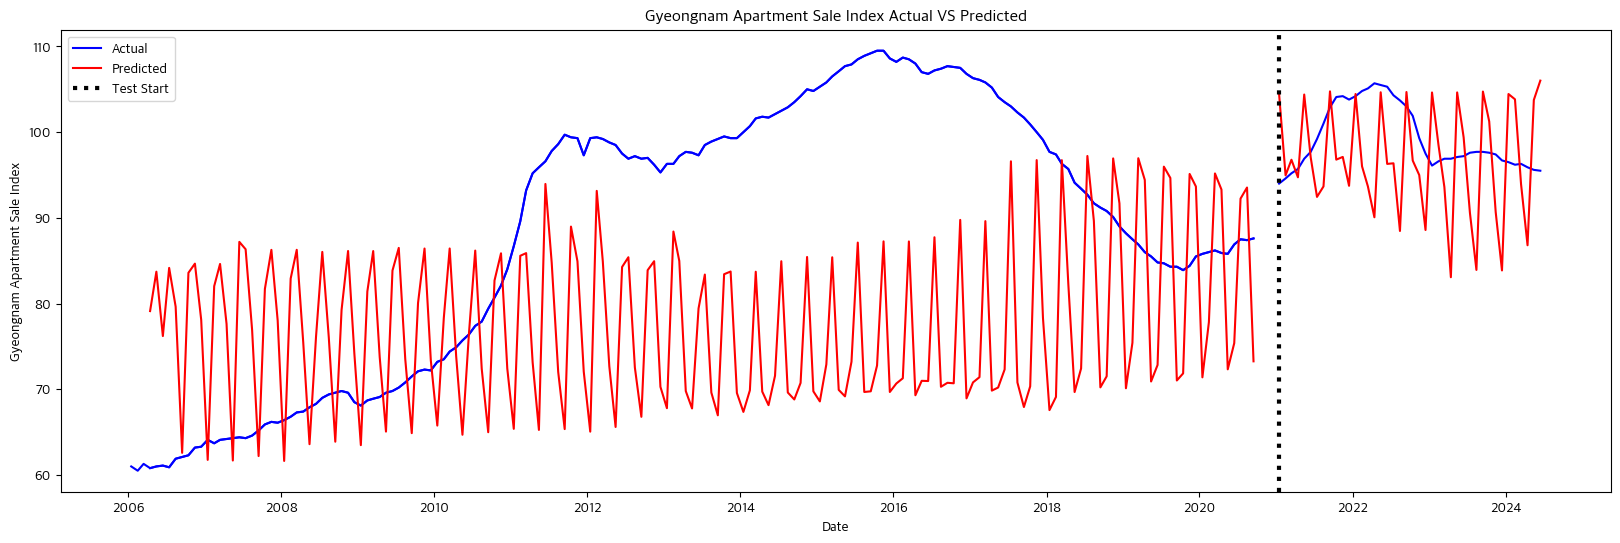

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input size 

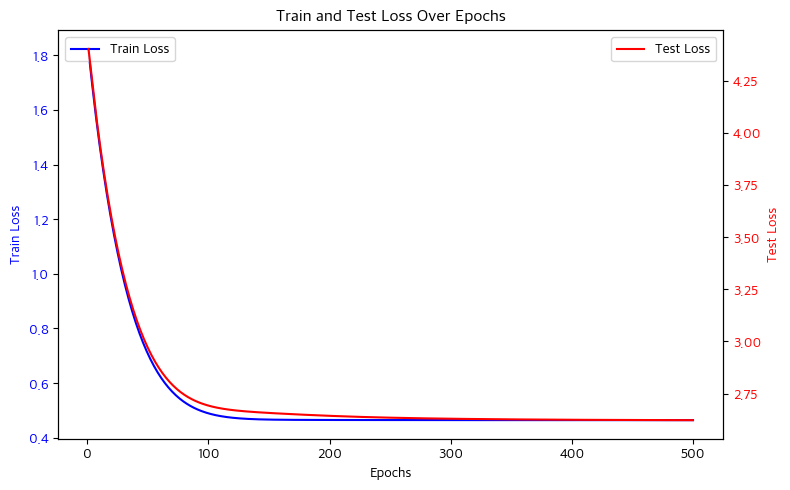

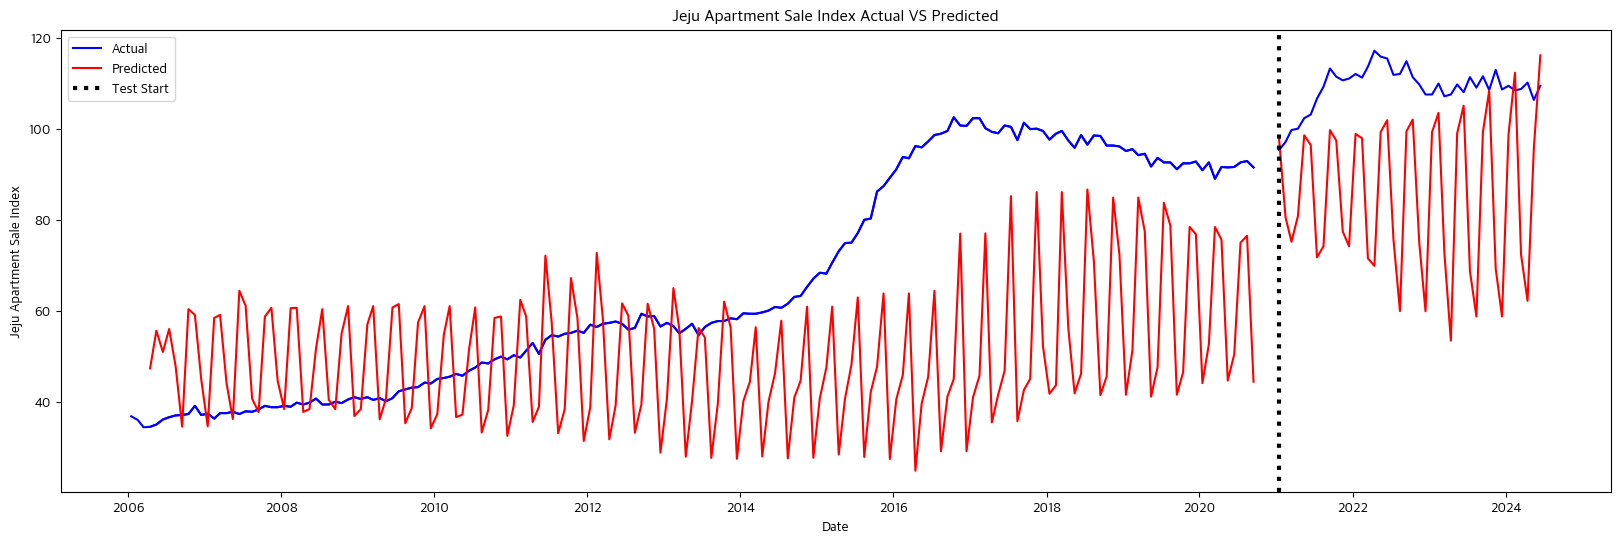

In [74]:
for i in range(len(target_column)):
    target_name = target_column[i] # Seoul
    targets = nf.columns[i] # Seoul_apartment_sale_price_index

    # Prepare Dataset
    train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, targets)
    columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", 
                  "residential_building_start_status"] + [targets]
    train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    # Prepare DataLoader 
    train_ds = Data(train_x, train_y)
    test_ds = Data(test_x, test_y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
    # Train the model 
    train_loss_list = [] # save the train loss
    test_loss_list = [] # save the test loss

    # Define the model
    DLinear_model = DLinear(configs=configs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    patience_counter = 0

    for epoch in tqdm(range(1, epoch+1)):
        loss_list = []
        DLinear_model.train()
        train_loss = 0.0 
        for batch_idx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        train_loss = np.mean(loss_list) 
        train_loss_list.append(train_loss) 

        DLinear_model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for data, target in test_dl:
                output = DLinear_model(data)
                test_loss = criterion(output, target.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
            
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        if train_loss < max_loss:
            torch.save(DLinear_model.state_dict(), f"./DLinear_{version}_{target_name}.pth")
            max_loss = train_loss
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = train_loss
            dlinear_best_test_loss = test_loss
        else:
            patience_counter += 1
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
    ### Plot Loss Result ###
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(train_loss_list) + 1)
    ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    # ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    # ax2.grid()
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Load model and Evaluate
    DLinear_model.load_state_dict(torch.load(f"./DLinear_{version}_{target_name}.pth"))  # 최적 모델 로드
    DLinear_model.eval()
    te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
    tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
    
    # Calculate the prediction performance of test dataset
    real = test_targets
    pred = test_predictions
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target_name,rmse,r2,DS]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False) # save to file
    
    ### Plot Prediction Result ###
    plt.figure(figsize=(20,6))
    plt.title(f"{target_name} Apartment Sale Index Actual VS Predicted")
    plt.plot(train_df[date], train_df[targets], c='b',label="Actual")
    plt.plot(tr_dates, train_targets, c='b')
    plt.plot(tr_dates, train_predictions, c='r',label="Predicted")
    plt.plot(te_dates, test_targets, c='b')
    plt.plot(te_dates, test_predictions, c='r')
    plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.xlabel('Date')
    plt.ylabel(f"{target_name} Apartment Sale Index")
    plt.legend()
    plt.show()

### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [70]:
### Experiment Setting
version = "V2"
window_size = 3
forecast_size= 3 
epoch = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = column + [nf.columns[0]] # exampel: Column defined before & Target
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=True,
    enc_in= len(columns_to_use) # feature_size
)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

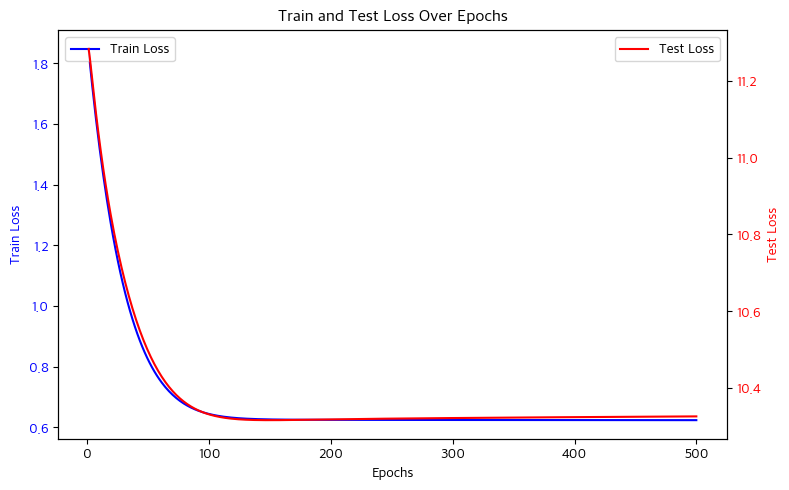

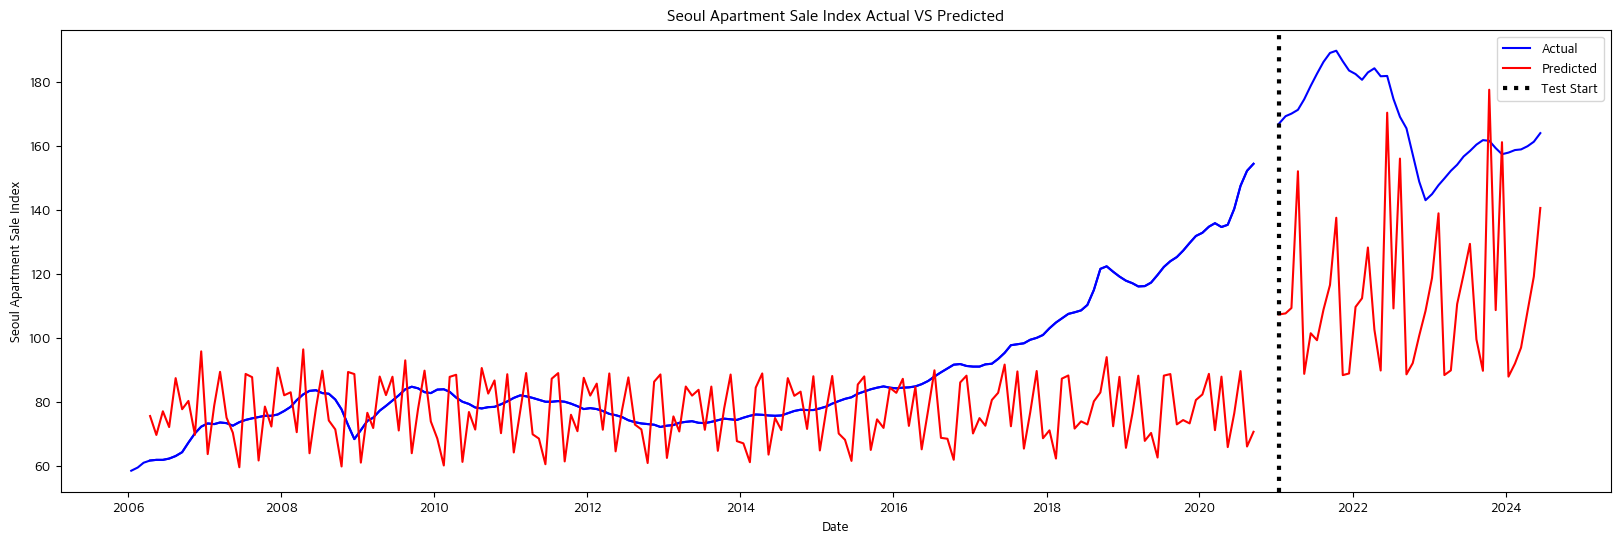

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

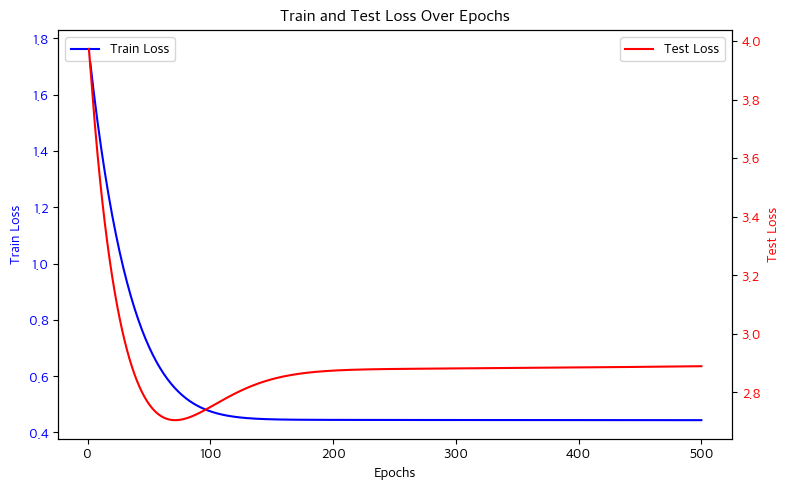

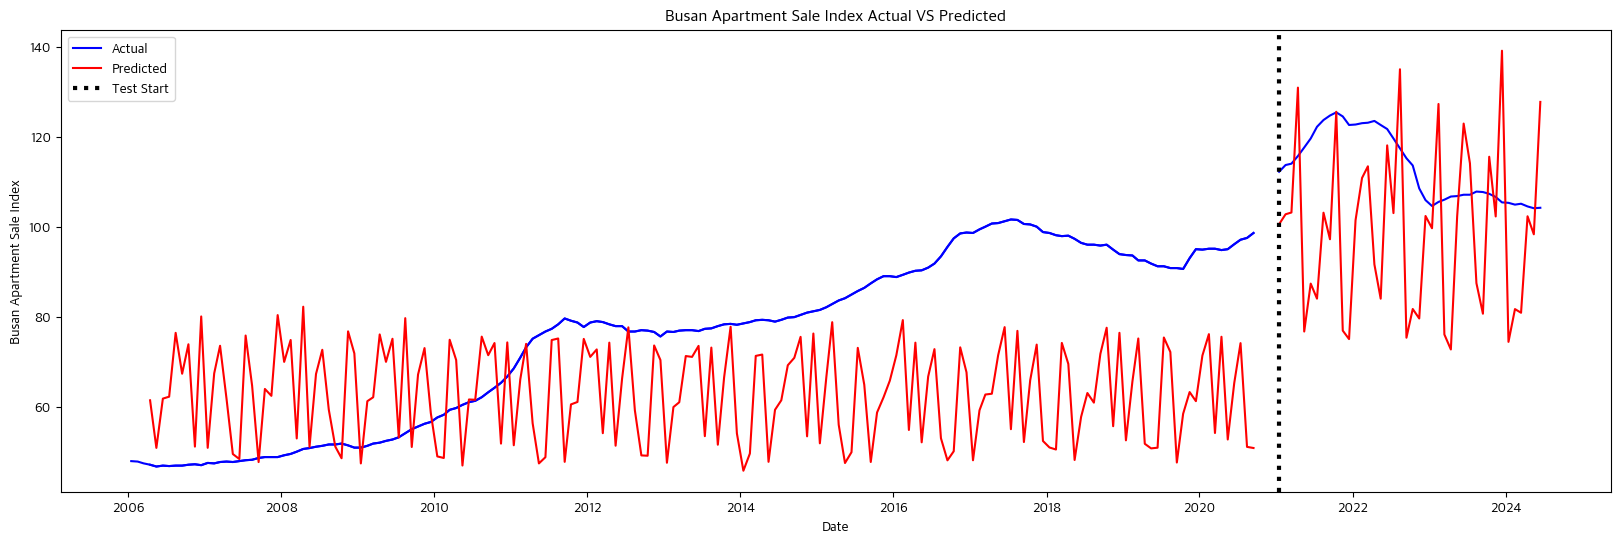

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

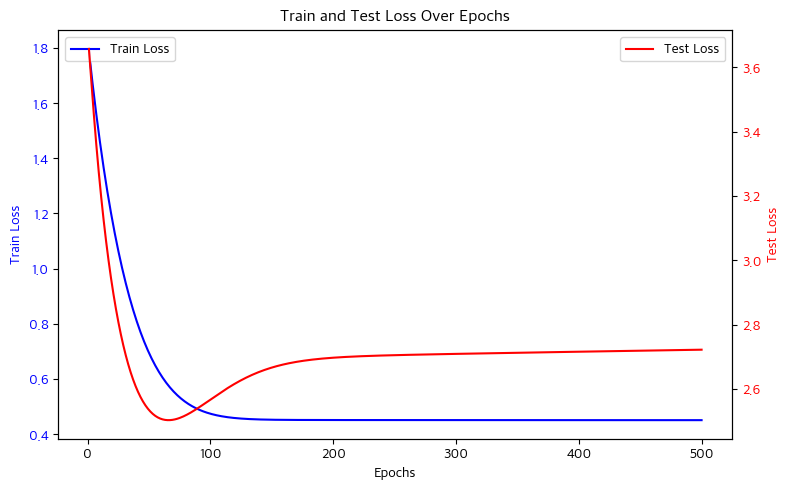

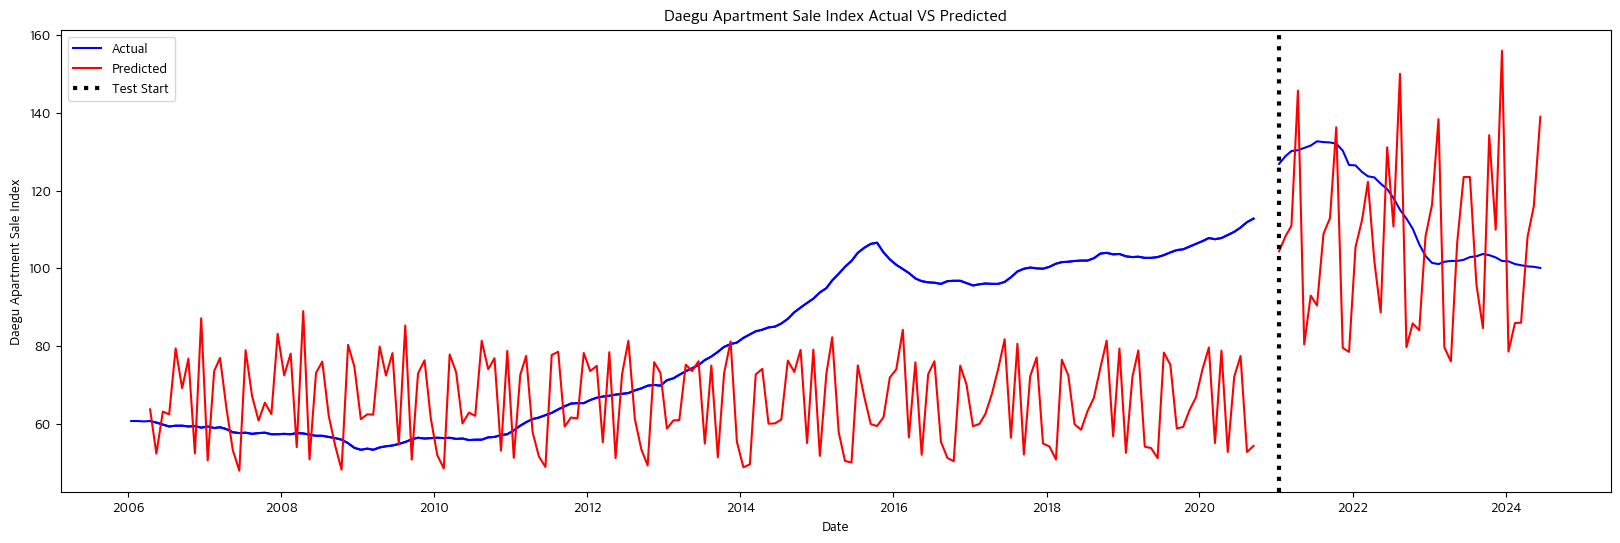

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

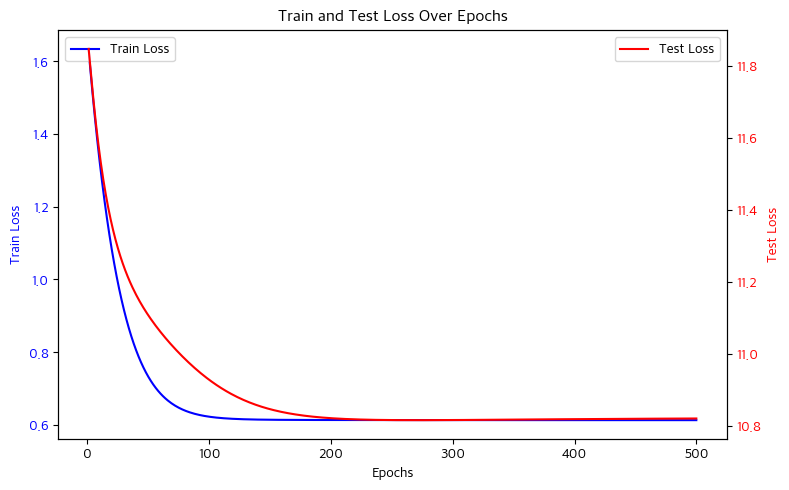

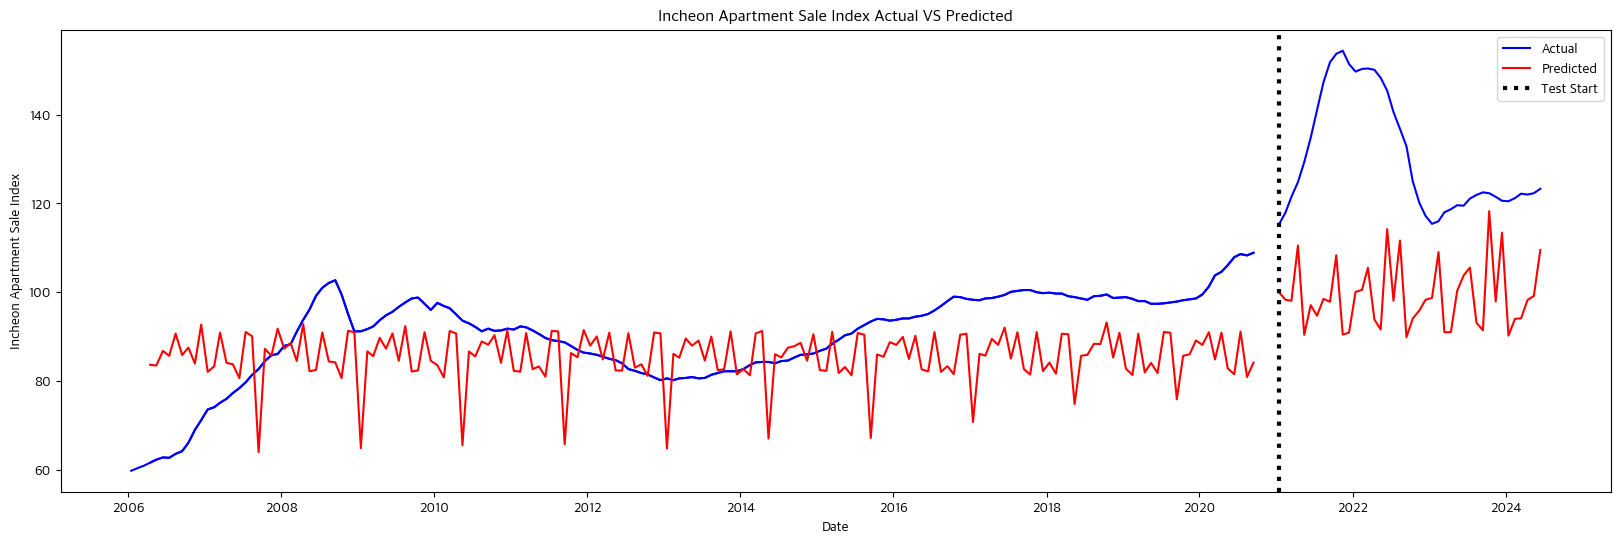

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

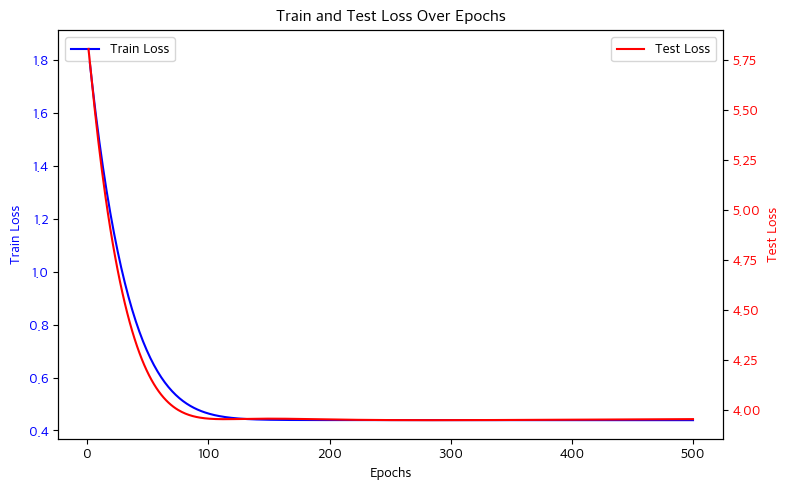

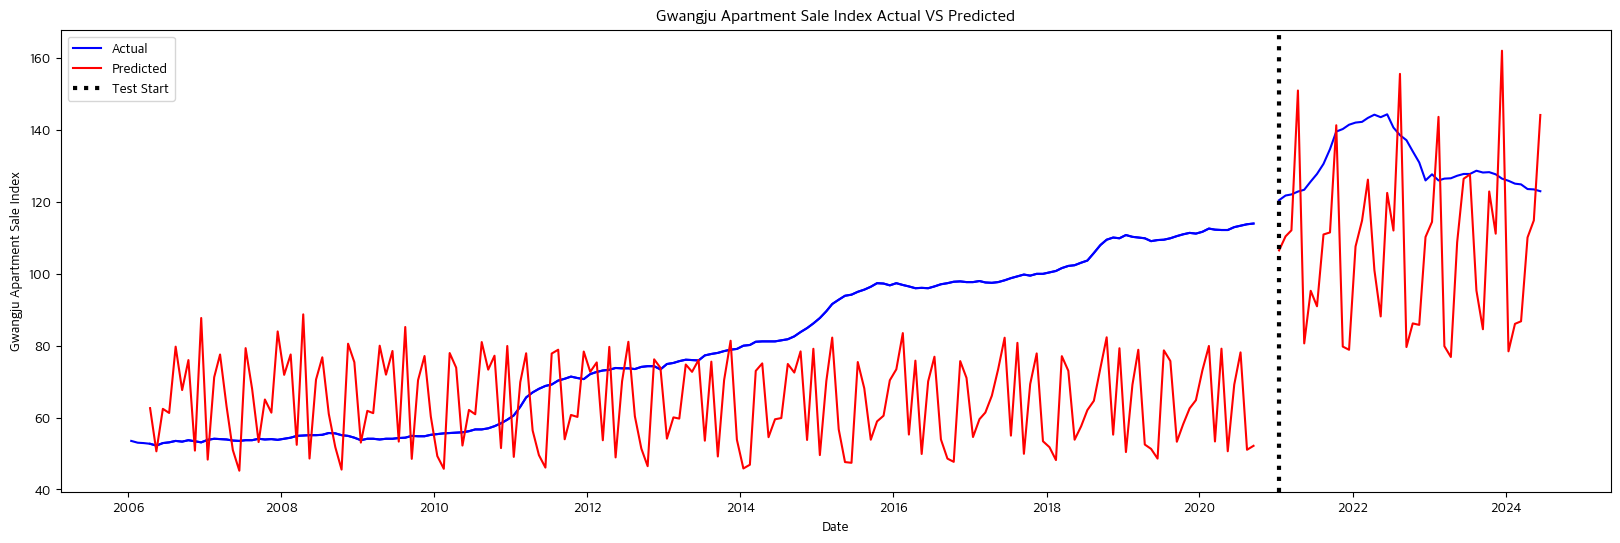

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

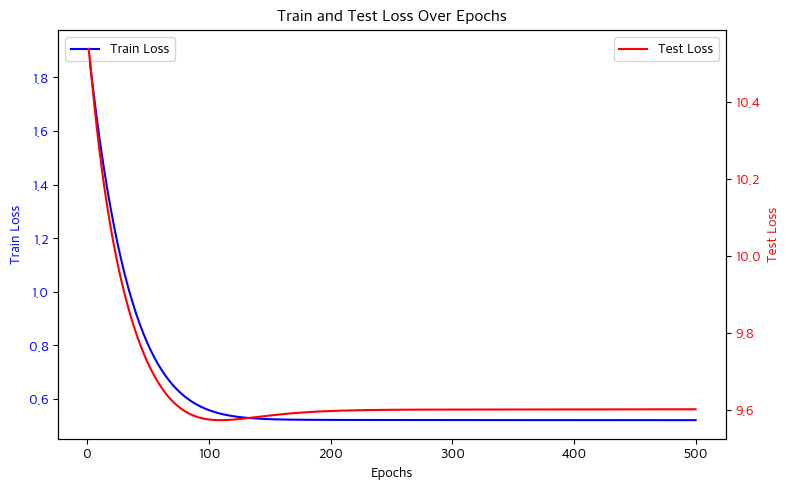

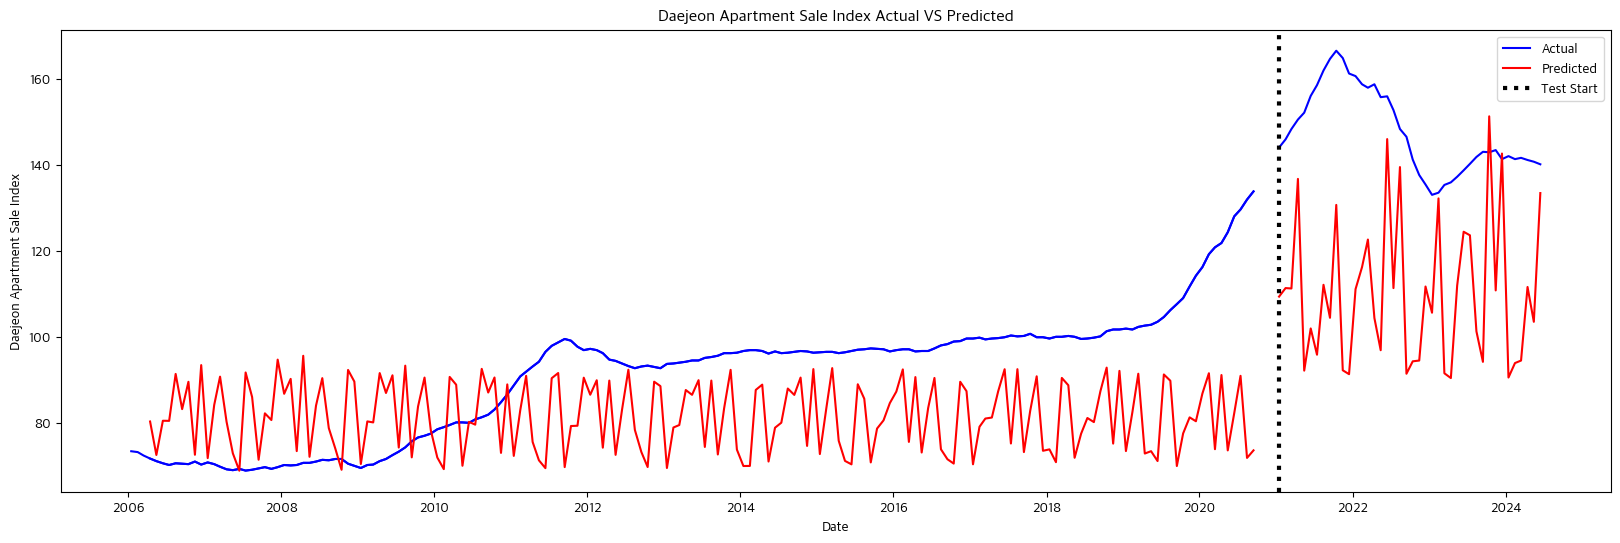

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

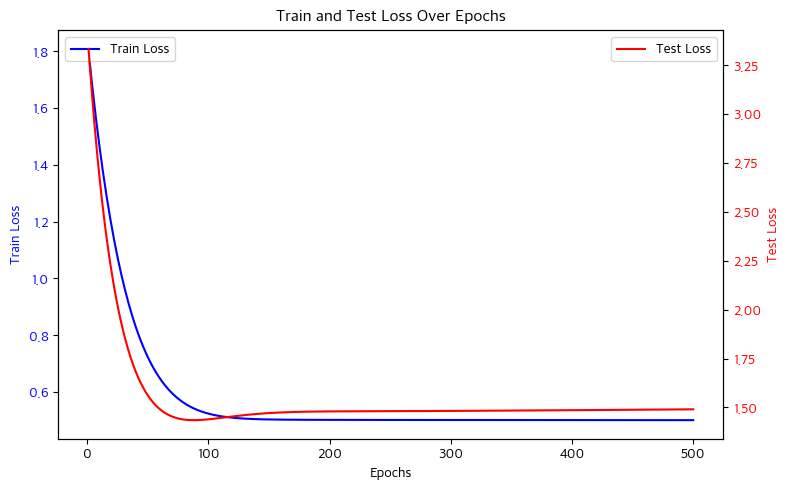

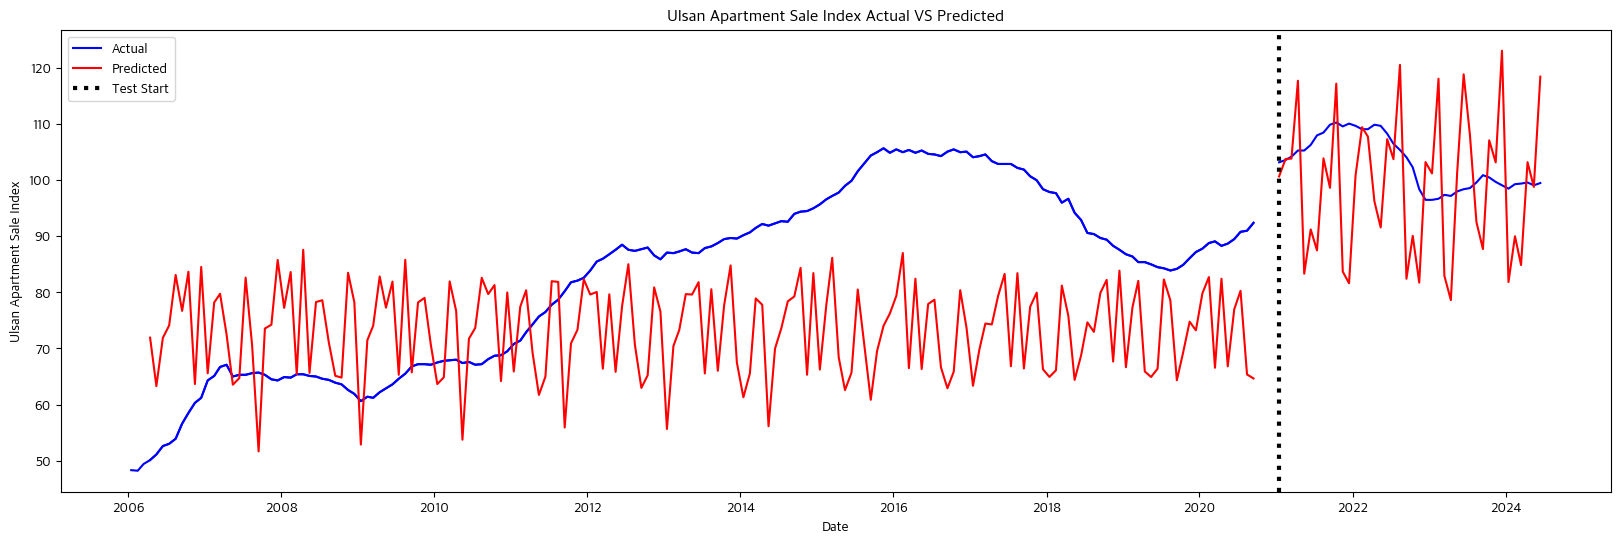

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

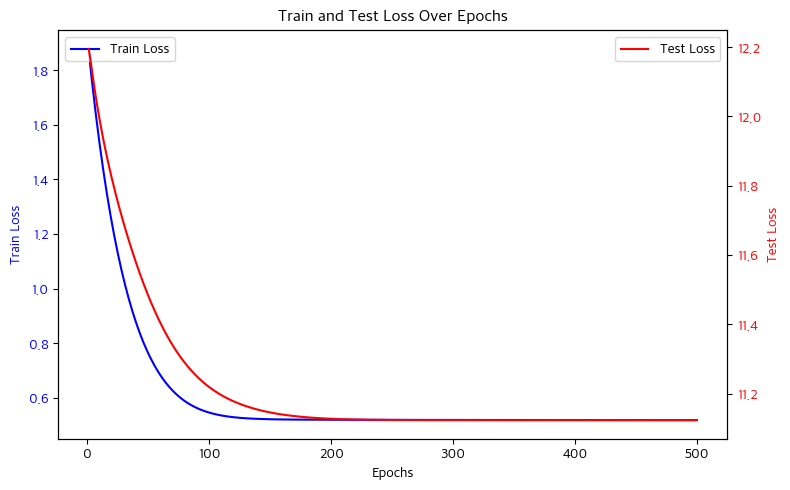

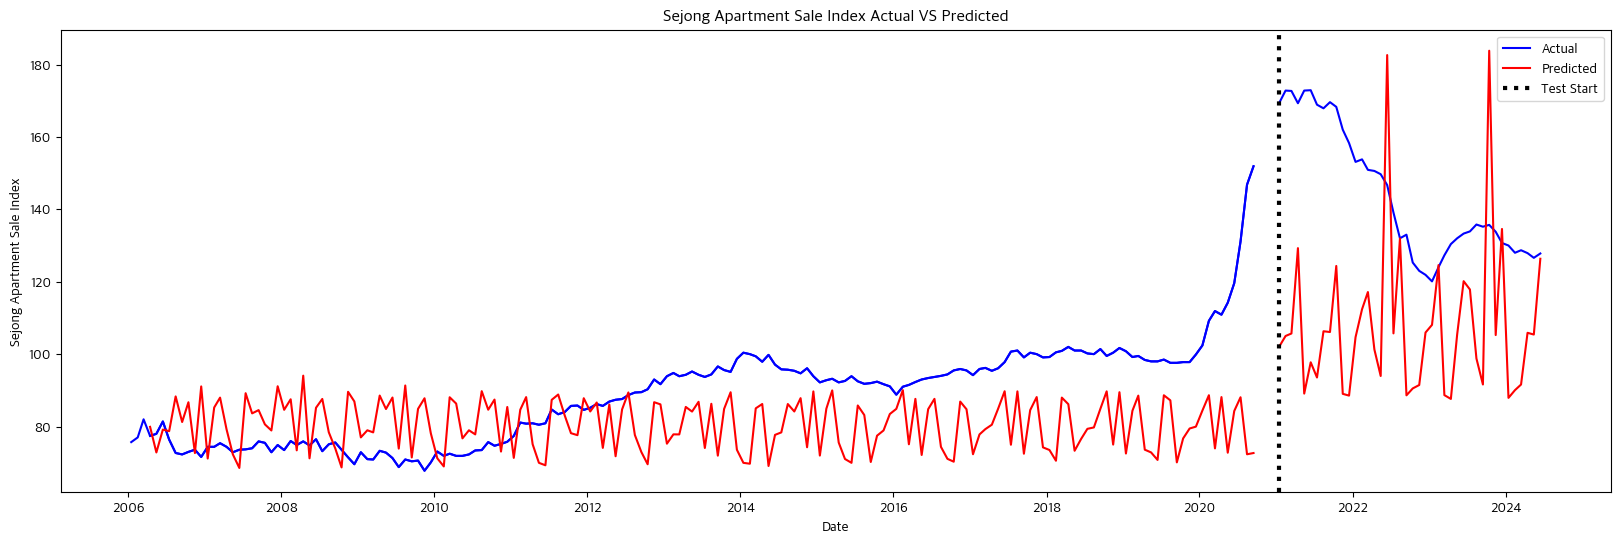

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

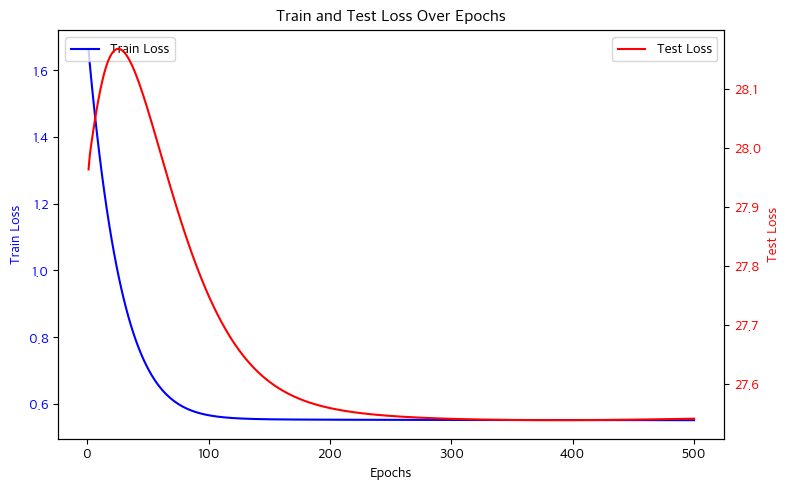

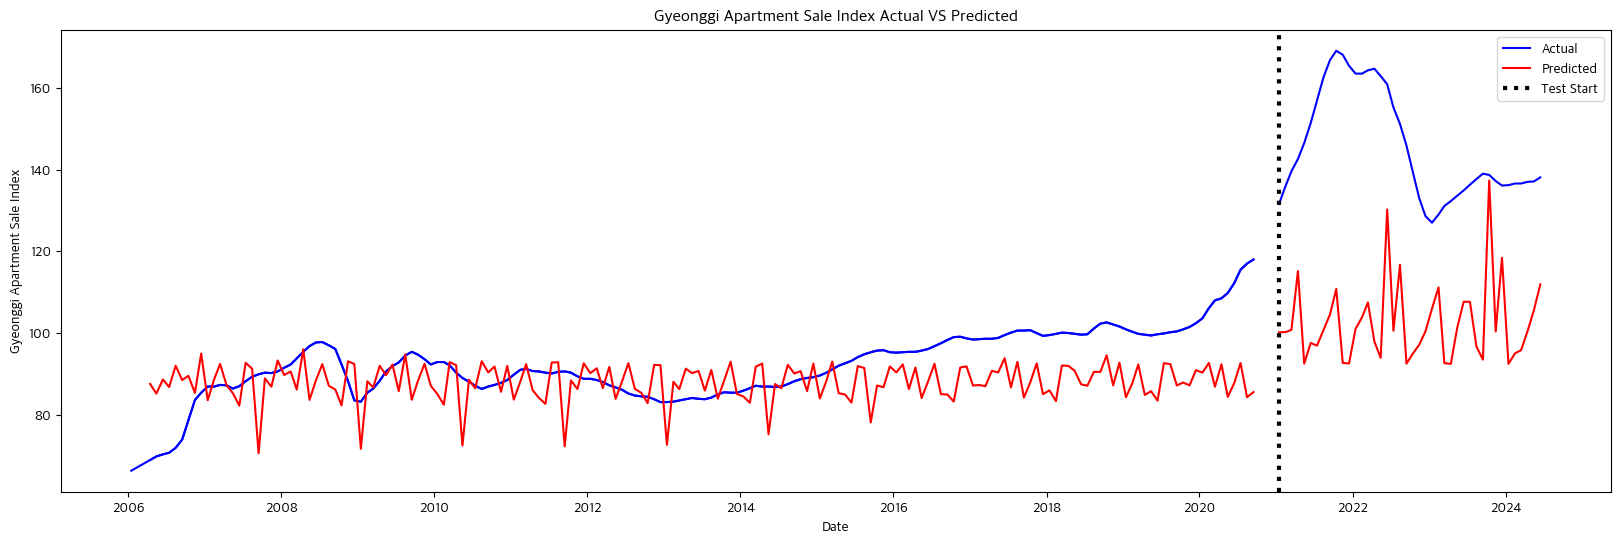

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

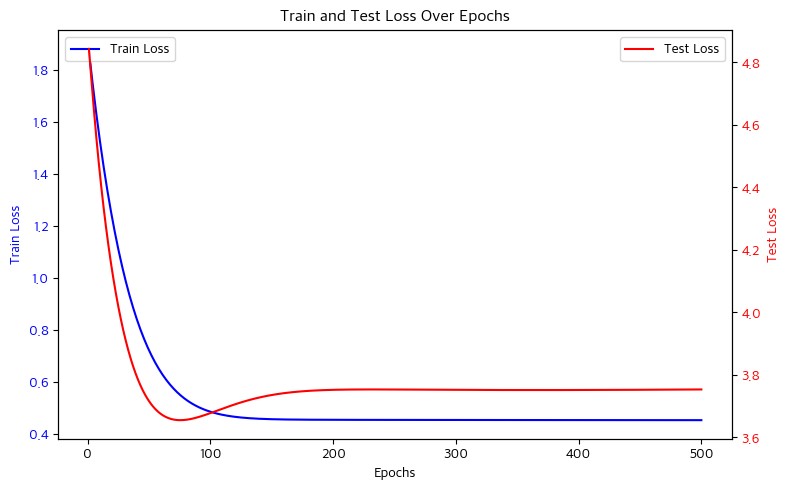

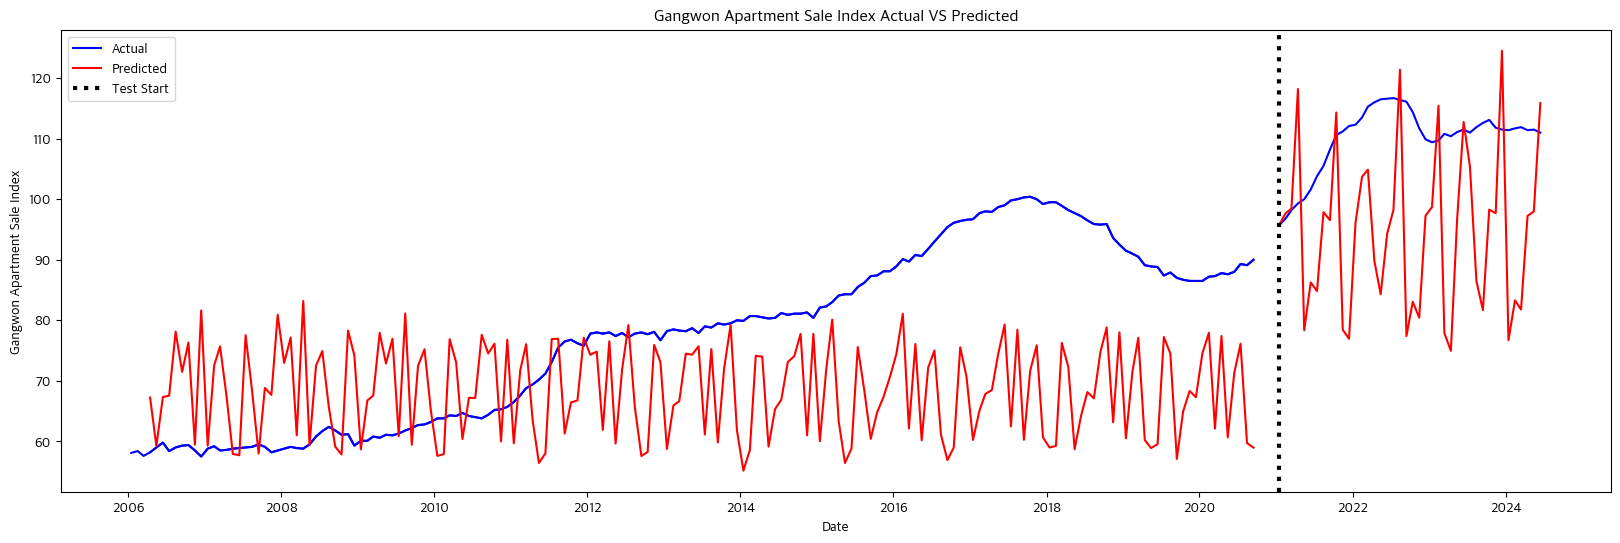

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

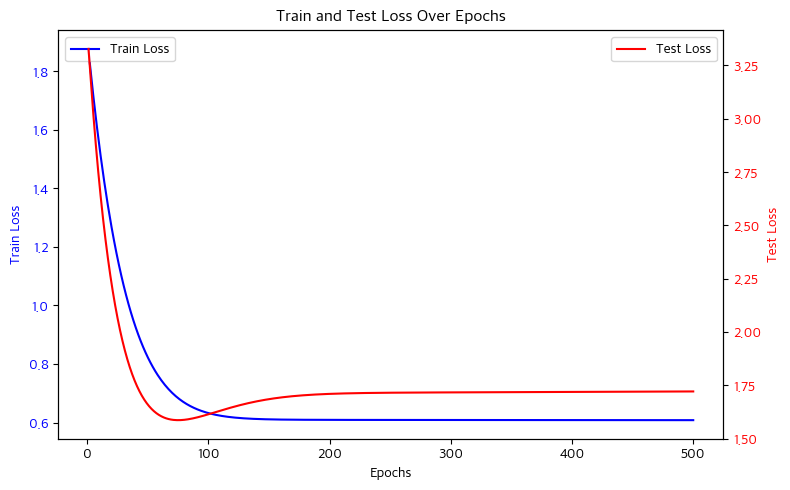

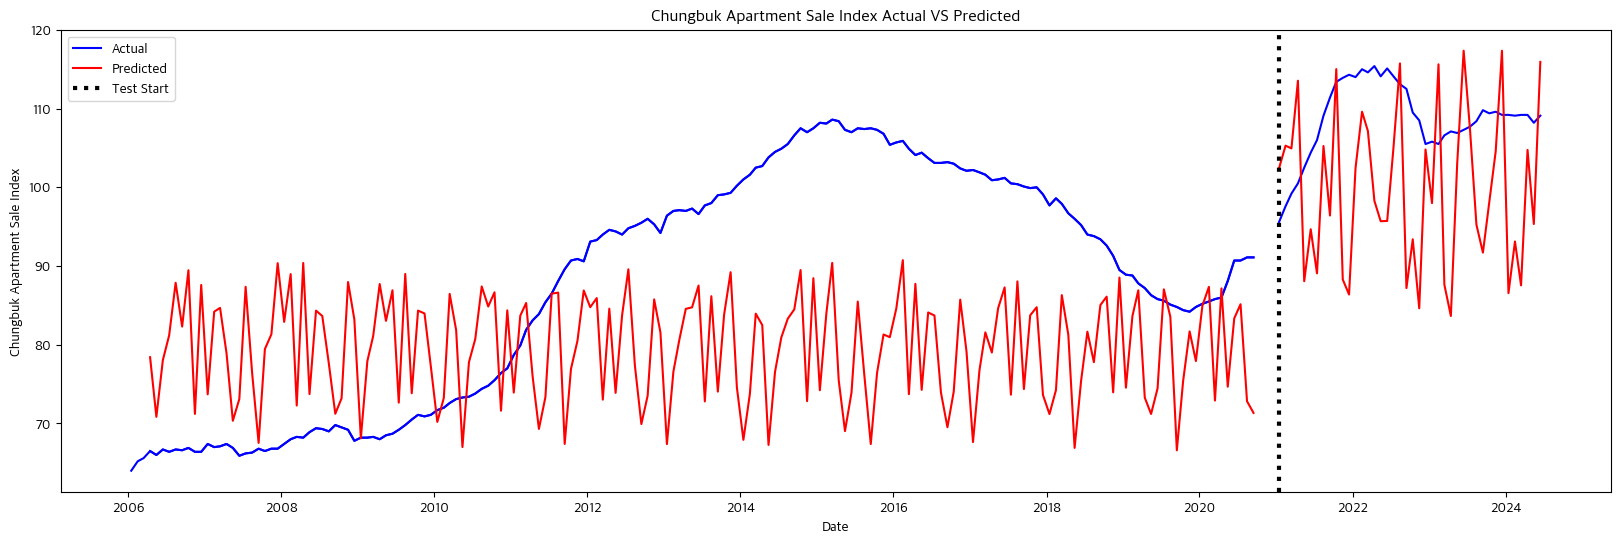

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

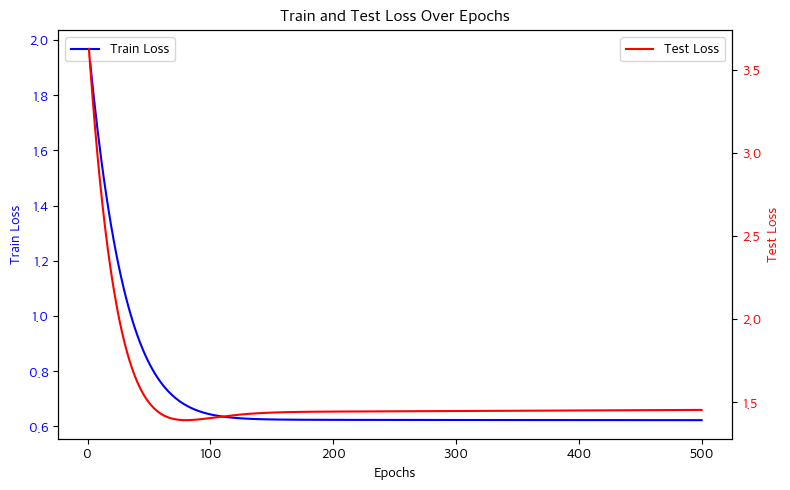

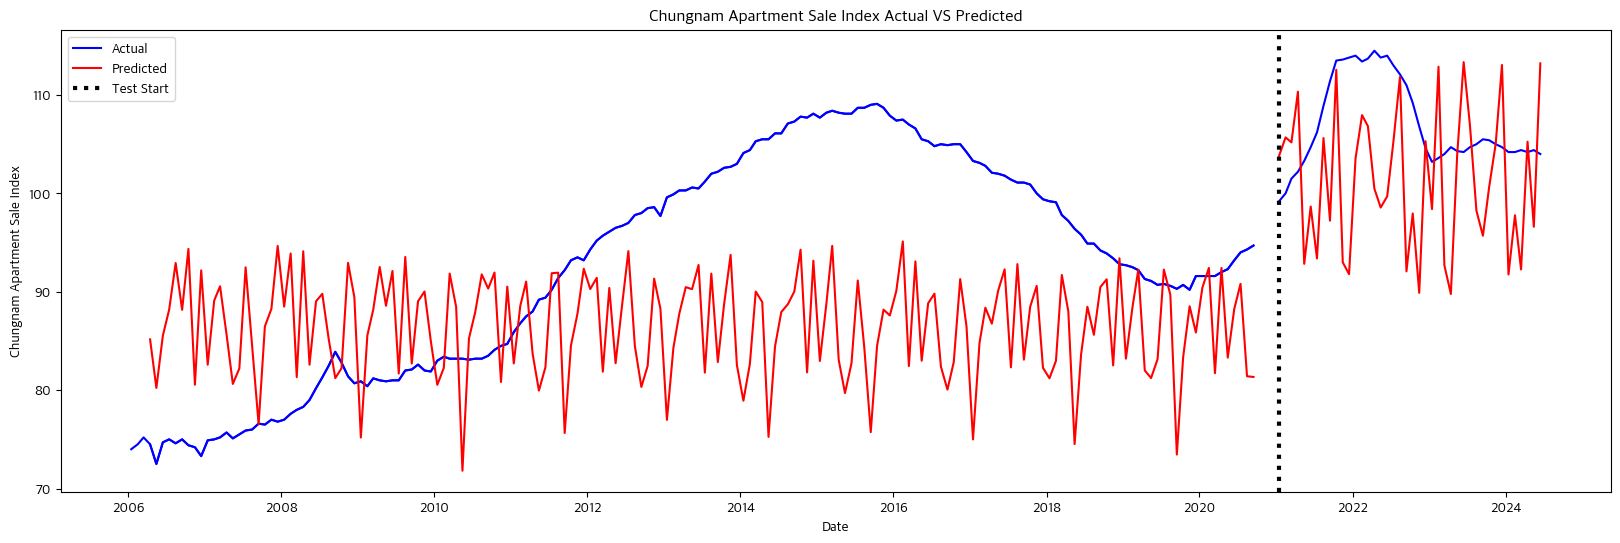

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

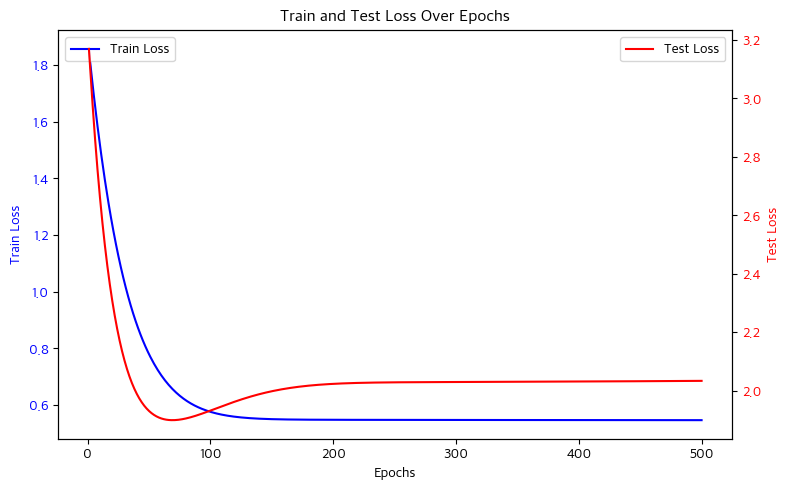

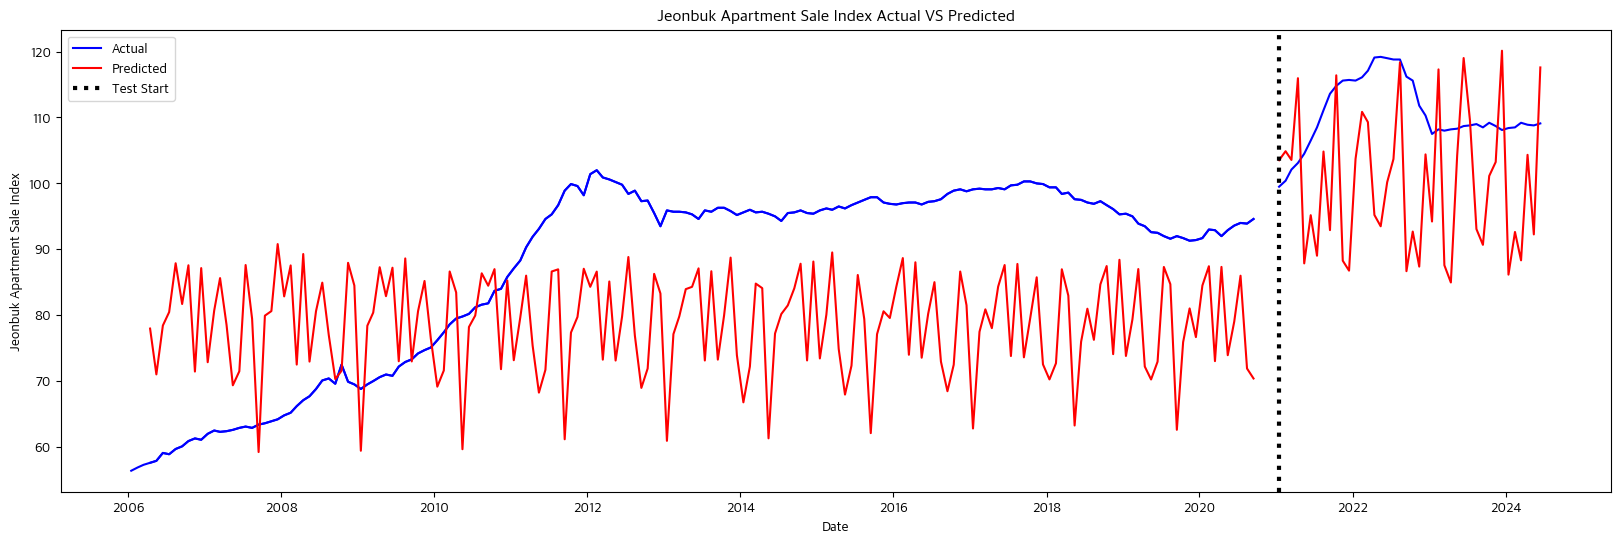

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

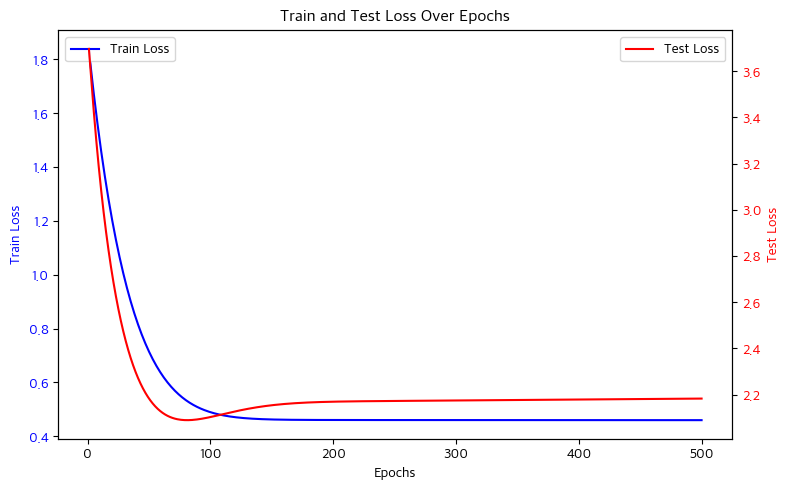

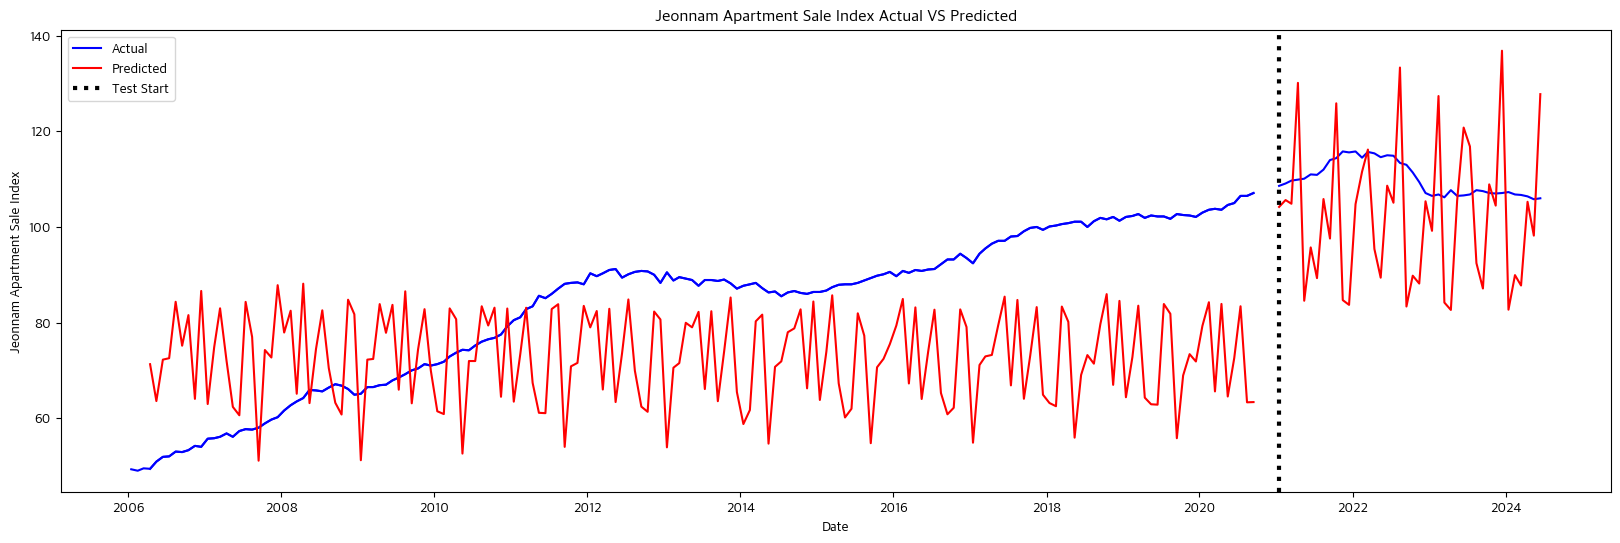

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

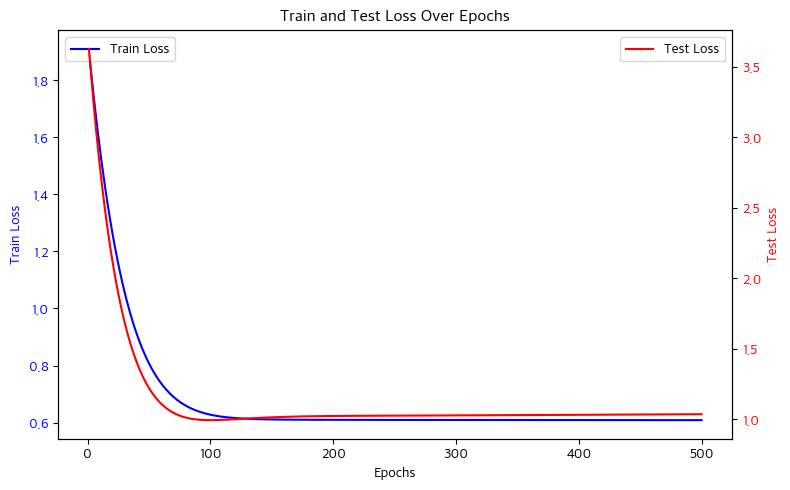

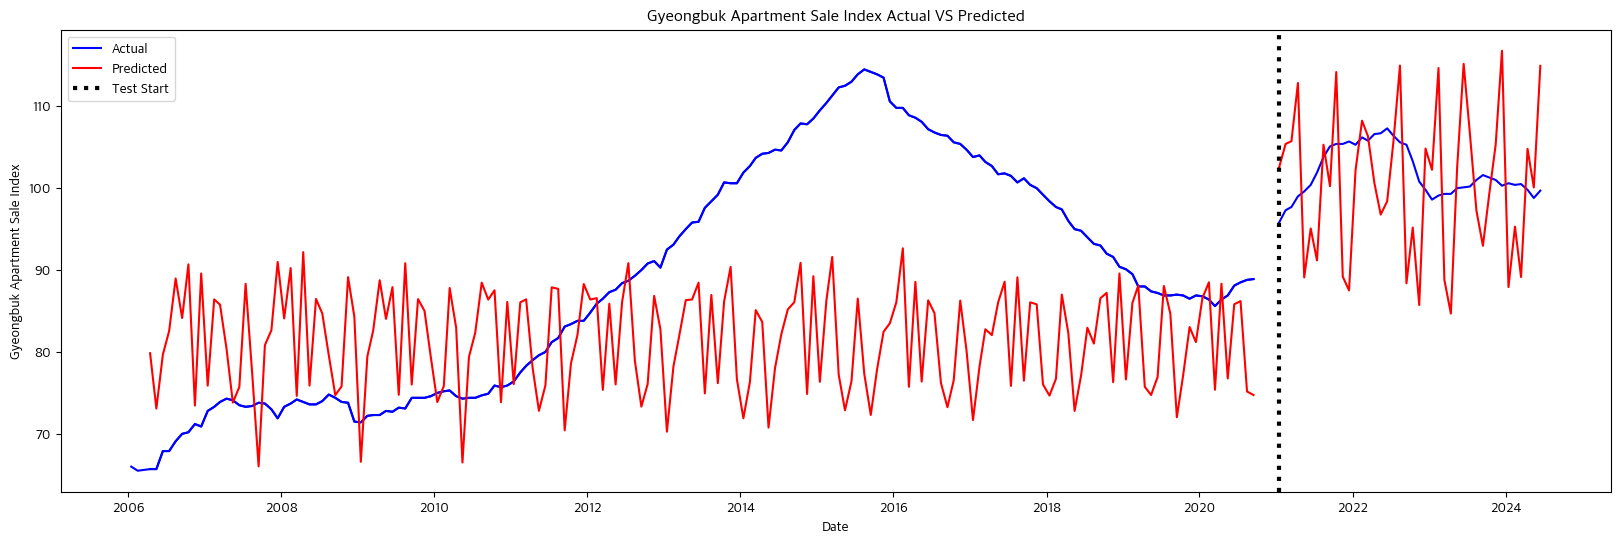

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

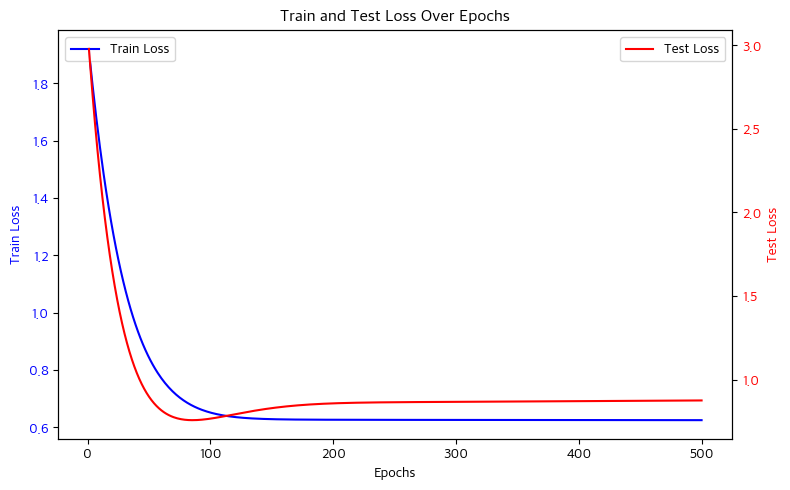

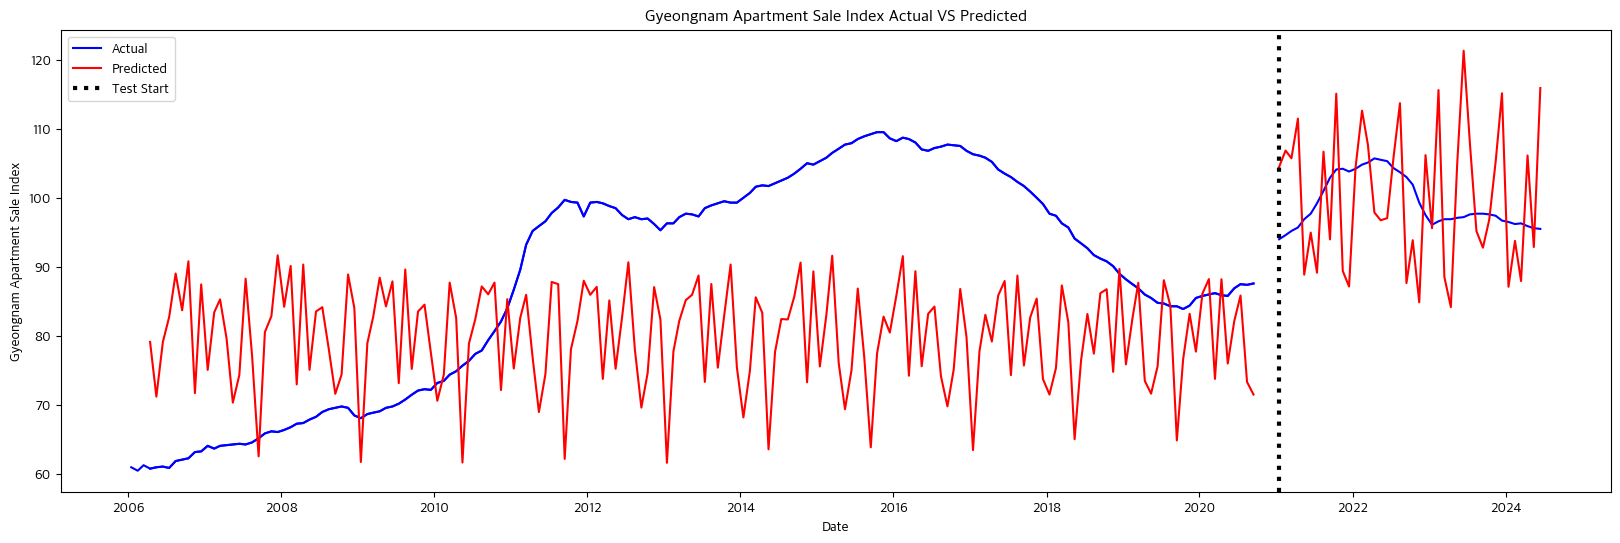

  0%|          | 0/500 [00:00<?, ?it/s]/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 3, 1])) that is different to the input size (torch.Size([16, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 3, 1])) that is different to the input size (torch.Size([12, 3, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 3, 1])) that is different to the input siz

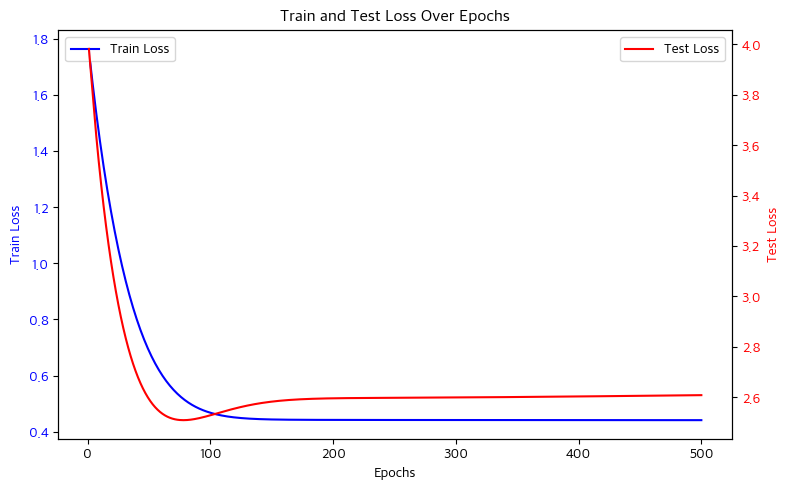

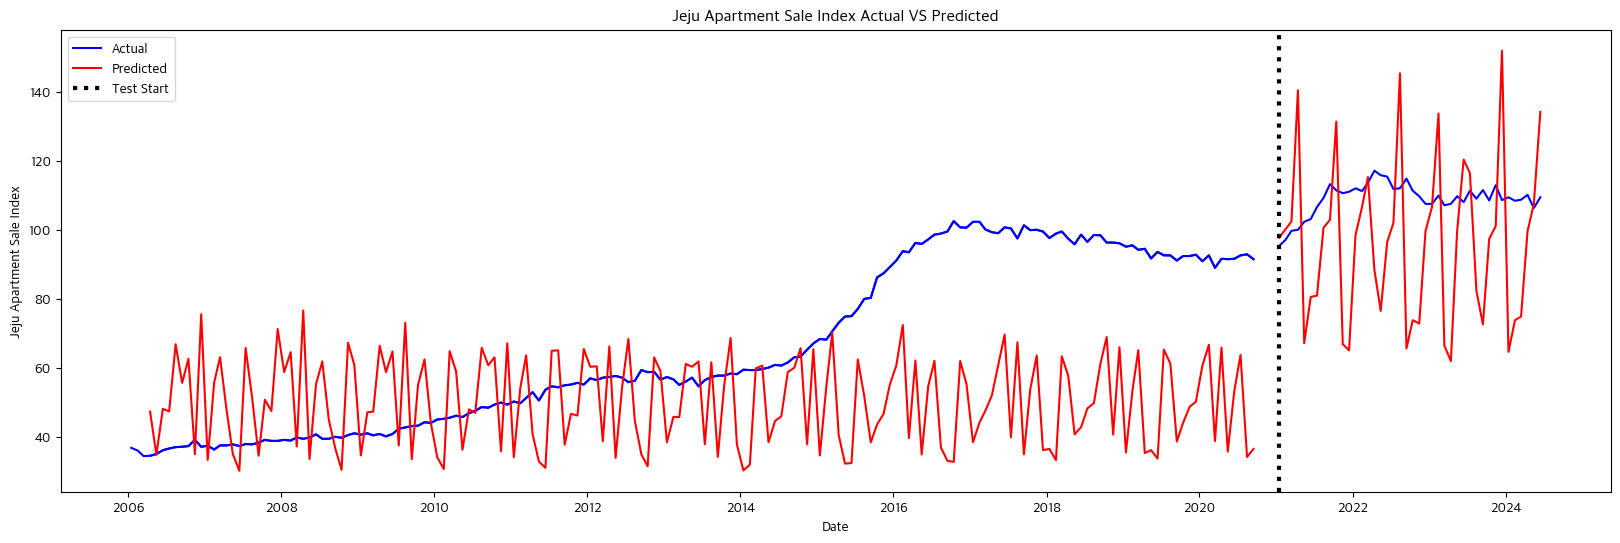

In [71]:
for i in range(len(target_column)):
    target_name = target_column[i] # Seoul
    targets = nf.columns[i] # Seoul_apartment_sale_price_index

    # Prepare Dataset
    train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, targets)
    columns_to_use = column + [targets]
    train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    # Prepare DataLoader 
    train_ds = Data(train_x, train_y)
    test_ds = Data(test_x, test_y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
    # Train the model 
    train_loss_list = [] # save the train loss
    test_loss_list = [] # save the test loss

    # Define the model
    DLinear_model = DLinear(configs=configs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    patience_counter = 0

    for epoch in tqdm(range(1, epoch+1)):
        loss_list = []
        DLinear_model.train()
        train_loss = 0.0 
        for batch_idx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        train_loss = np.mean(loss_list) 
        train_loss_list.append(train_loss) 

        DLinear_model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for data, target in test_dl:
                output = DLinear_model(data)
                test_loss = criterion(output, target.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
            
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        if train_loss < max_loss:
            torch.save(DLinear_model.state_dict(), f"./DLinear_{version}_{target_name}.pth")
            max_loss = train_loss
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = train_loss
            dlinear_best_test_loss = test_loss
        else:
            patience_counter += 1
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
    ### Plot Loss Result ###
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(train_loss_list) + 1)
    ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    # ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    # ax2.grid()
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Load model and Evaluate
    DLinear_model.load_state_dict(torch.load(f"./DLinear_{version}_{target_name}.pth"))  # 최적 모델 로드
    DLinear_model.eval()
    te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
    tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
    
    # Calculate the prediction performance of test dataset
    real = test_targets
    pred = test_predictions
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target_name,rmse,r2,DS]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False) # save to file
    
    ### Plot Prediction Result ###
    plt.figure(figsize=(20,6))
    plt.title(f"{target_name} Apartment Sale Index Actual VS Predicted")
    plt.plot(train_df[date], train_df[targets], c='b',label="Actual")
    plt.plot(tr_dates, train_targets, c='b')
    plt.plot(tr_dates, train_predictions, c='r',label="Predicted")
    plt.plot(te_dates, test_targets, c='b')
    plt.plot(te_dates, test_predictions, c='r')
    plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.xlabel('Date')
    plt.ylabel(f"{target_name} Apartment Sale Index")
    plt.legend()
    plt.show()

### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [75]:
### Experiment Setting
version = "V3"
window_size = 3
forecast_size= 3 
epoch = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = [nf.columns[0]] # exampel: Column defined before & Target
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=False,
    enc_in= len(columns_to_use) # feature_size
)

else


100%|██████████| 500/500 [00:10<00:00, 48.63it/s]


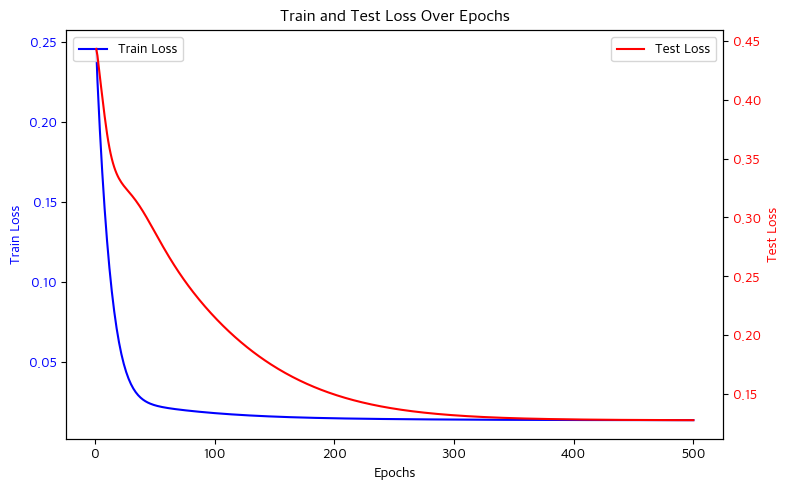

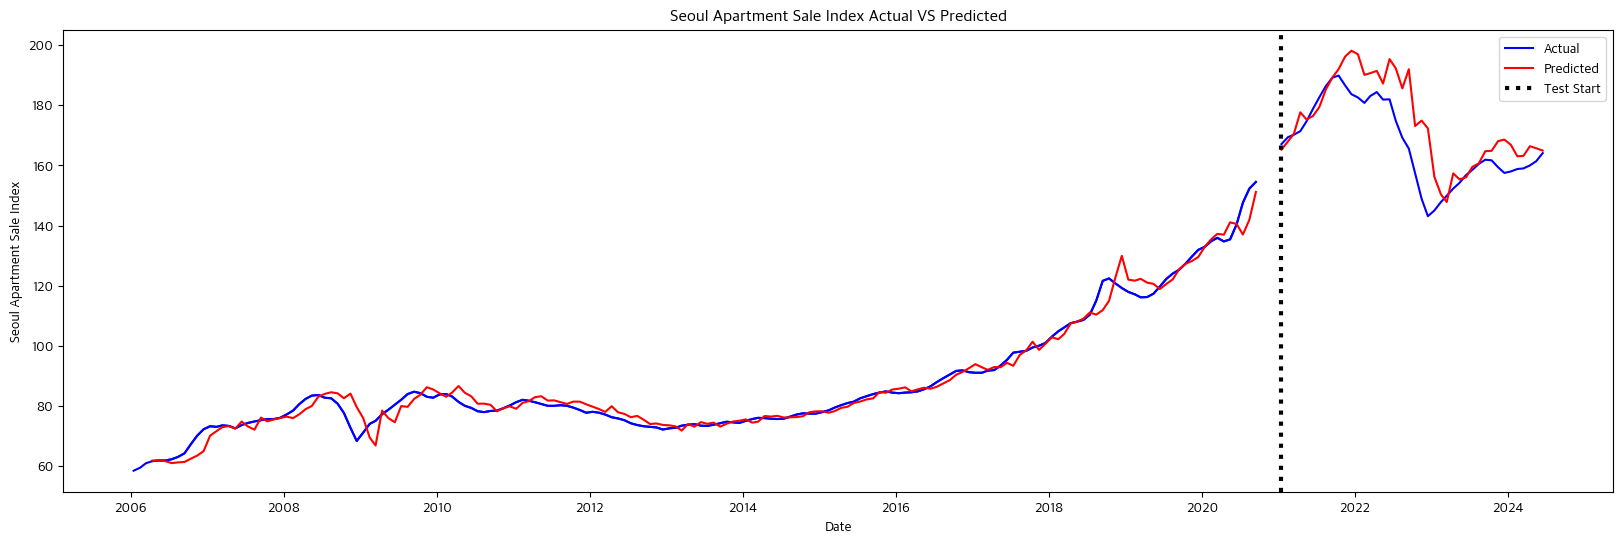

else


100%|██████████| 500/500 [00:09<00:00, 54.17it/s]


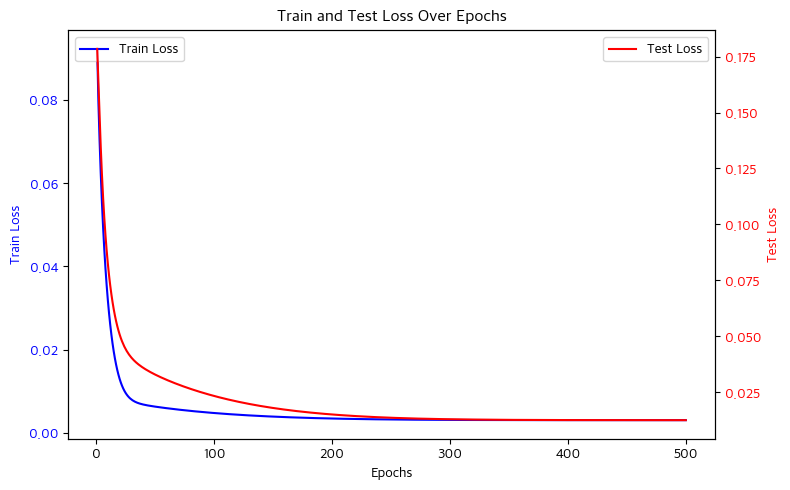

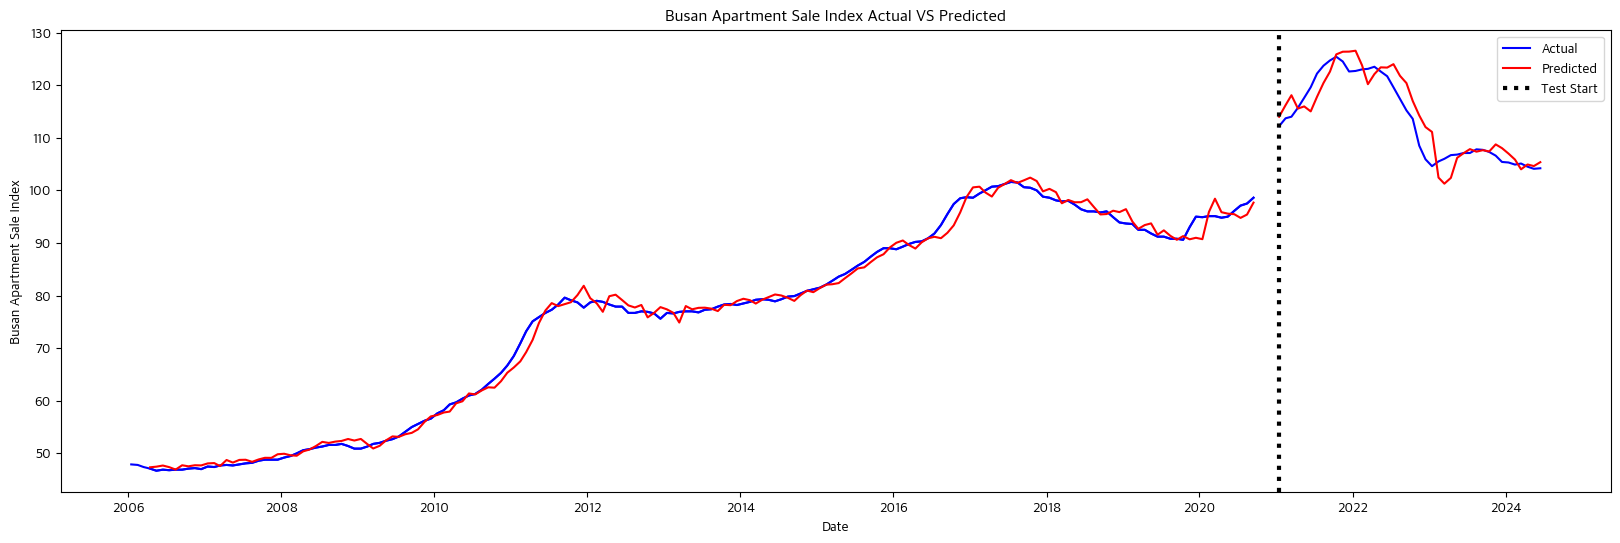

else


100%|██████████| 500/500 [00:09<00:00, 53.92it/s]


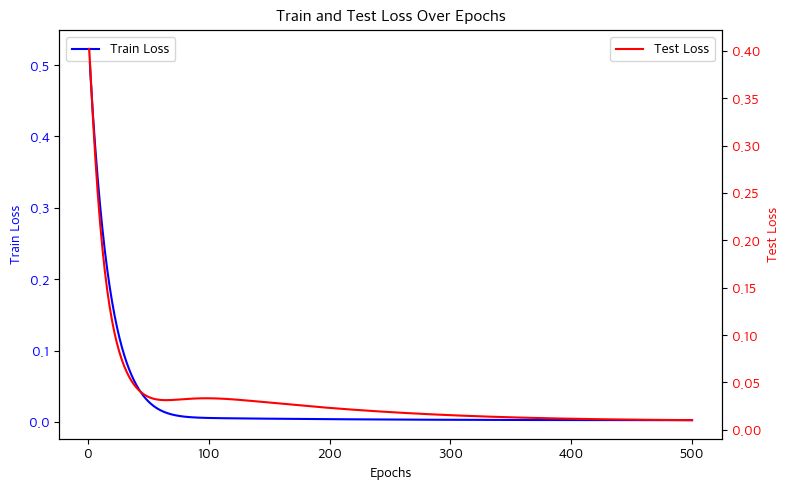

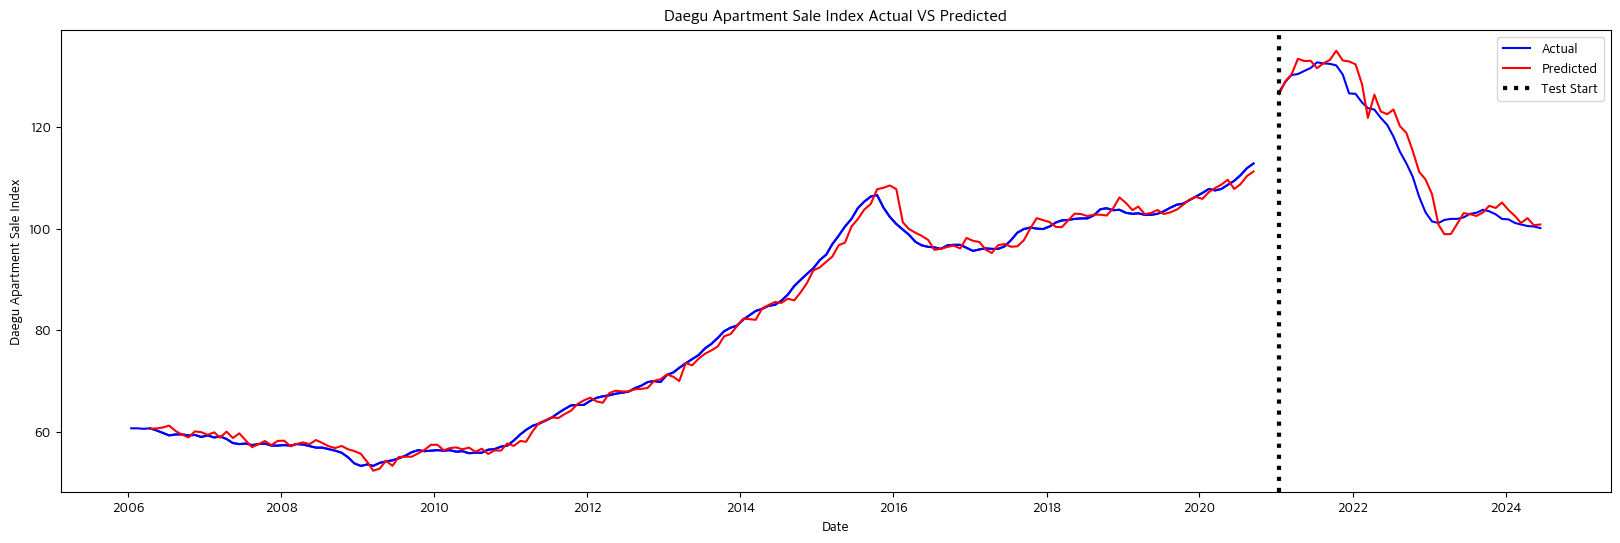

else


100%|██████████| 500/500 [00:09<00:00, 51.41it/s]


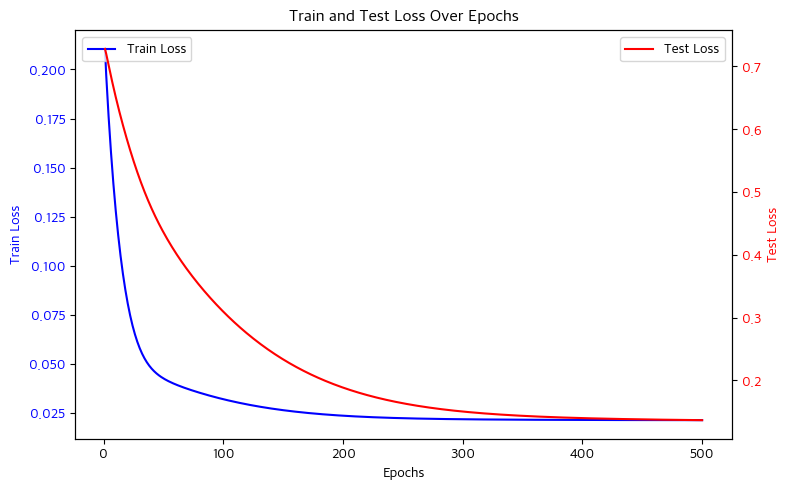

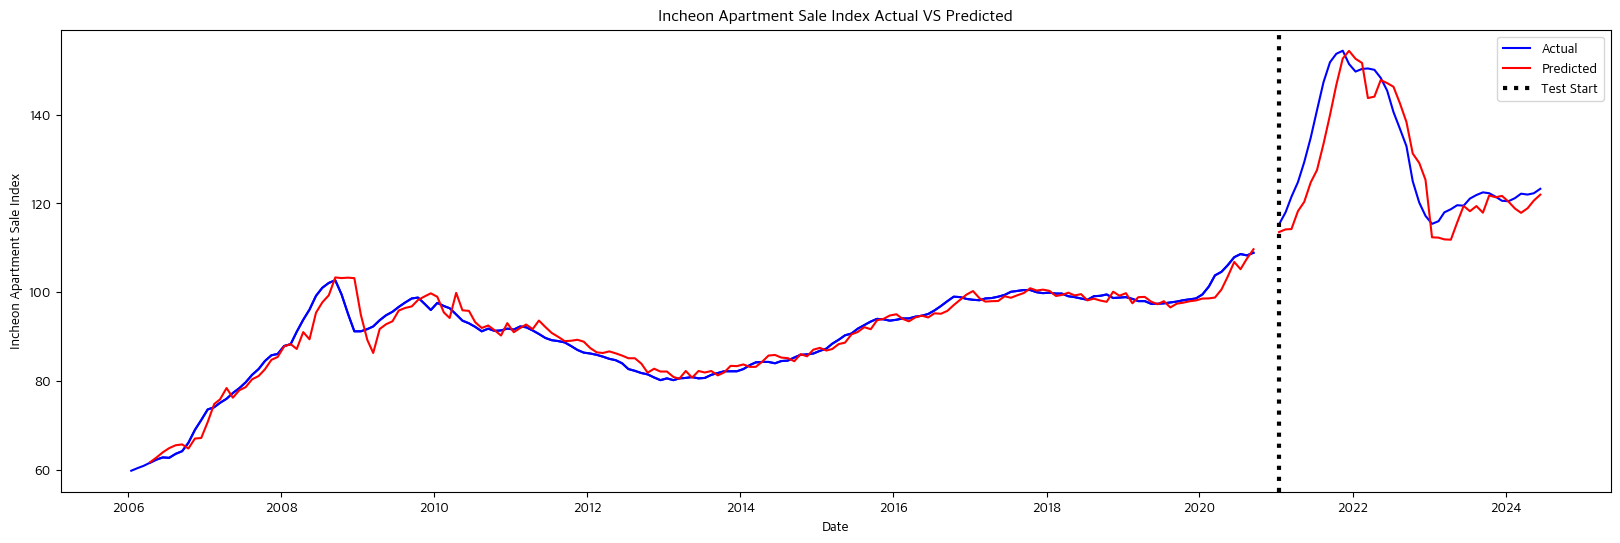

else


100%|██████████| 500/500 [00:10<00:00, 48.34it/s]


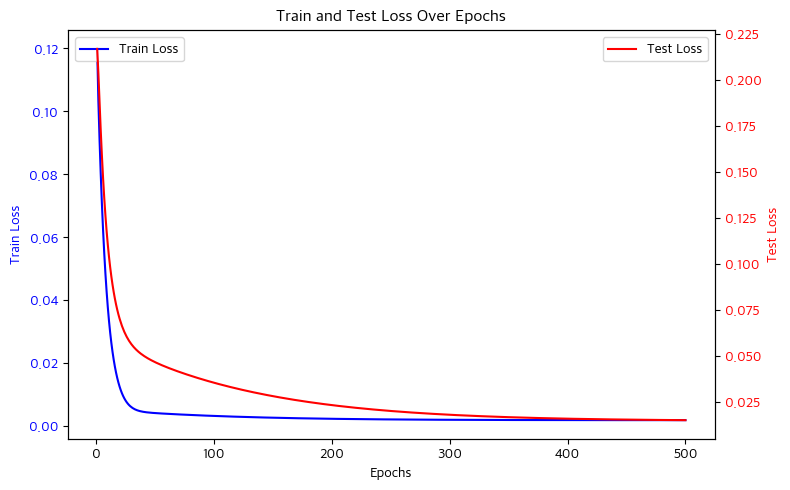

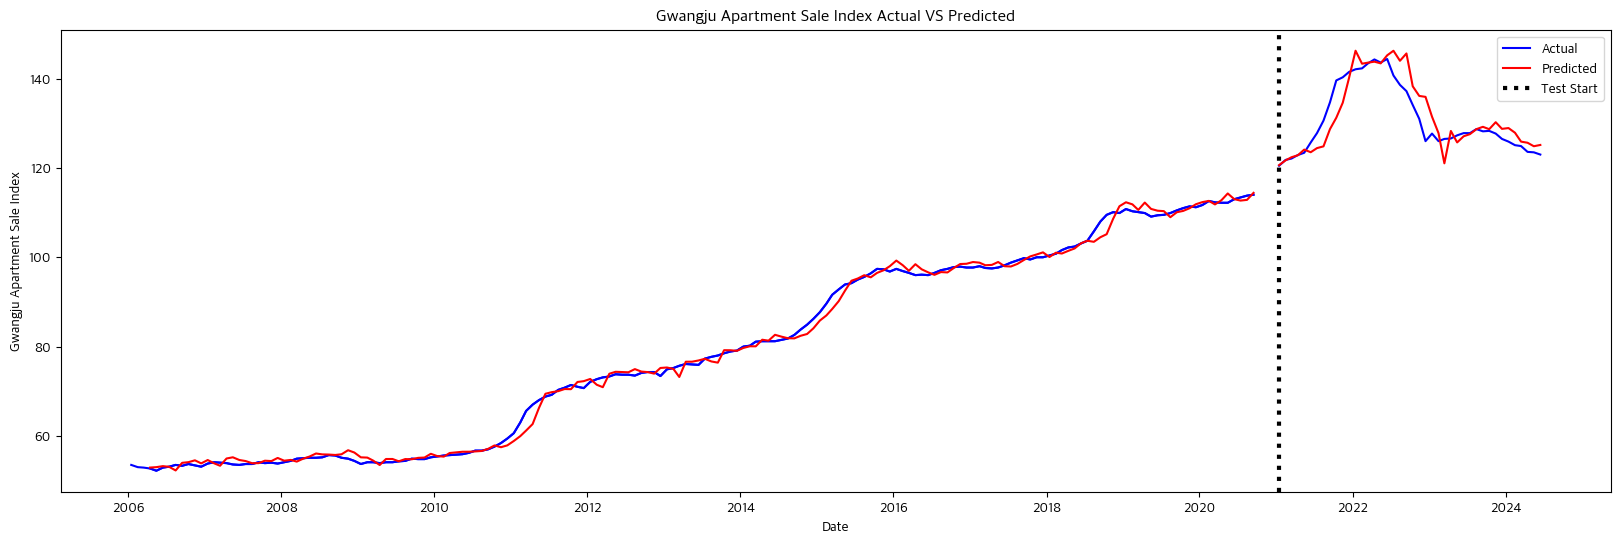

else


100%|██████████| 500/500 [00:09<00:00, 52.00it/s]


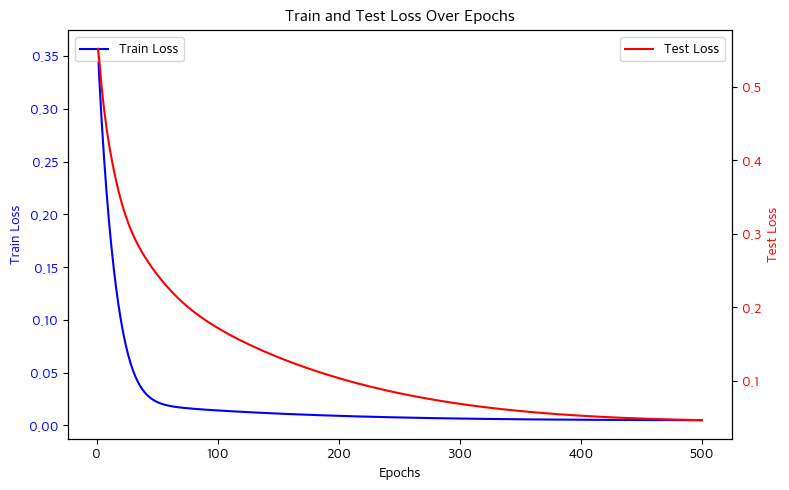

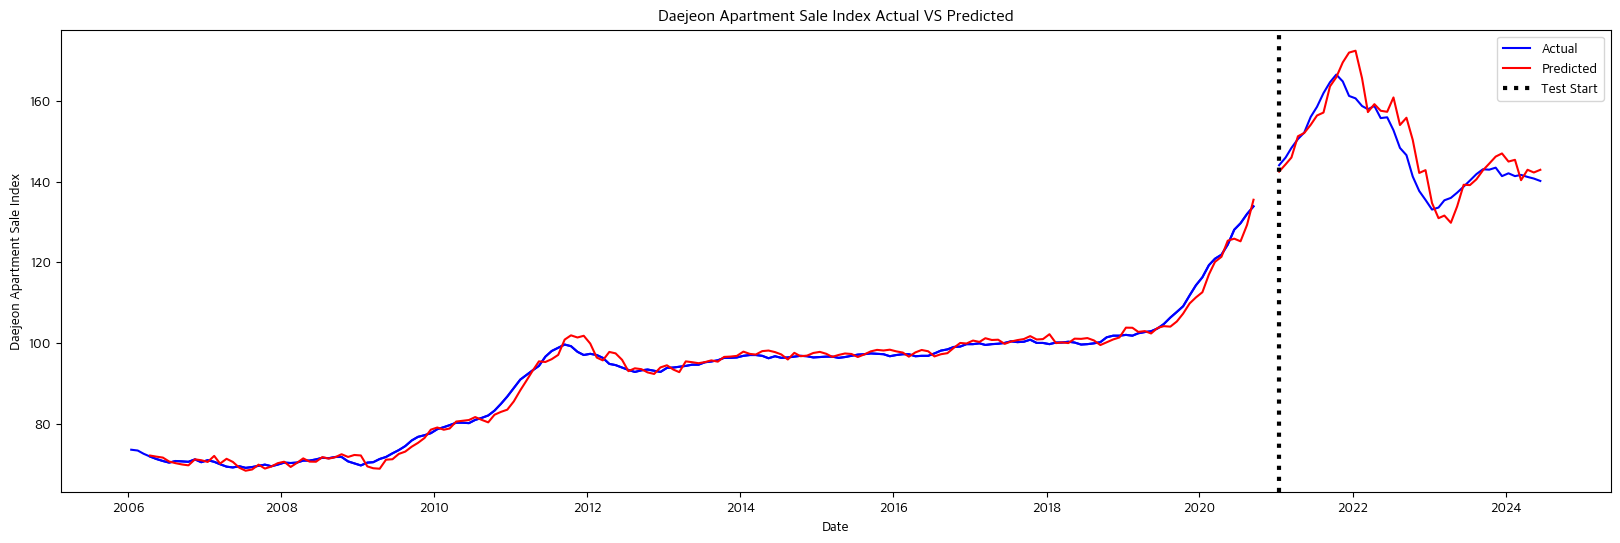

else


 89%|████████▊ | 443/500 [00:09<00:01, 48.08it/s]


Early stopping triggered.


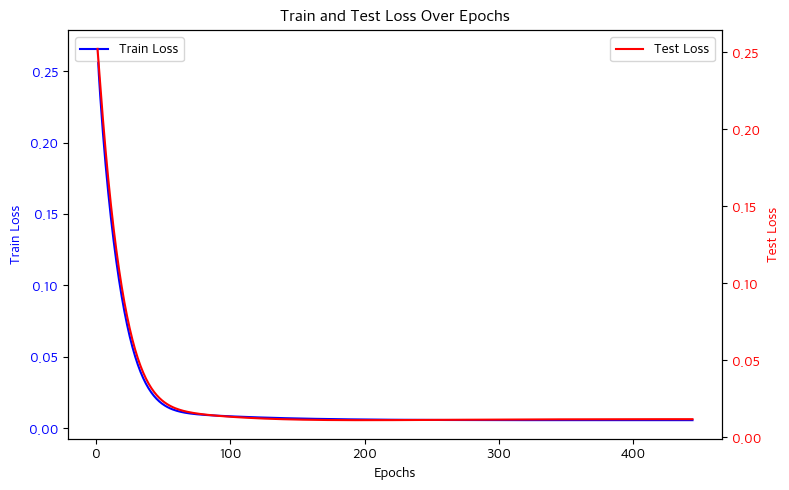

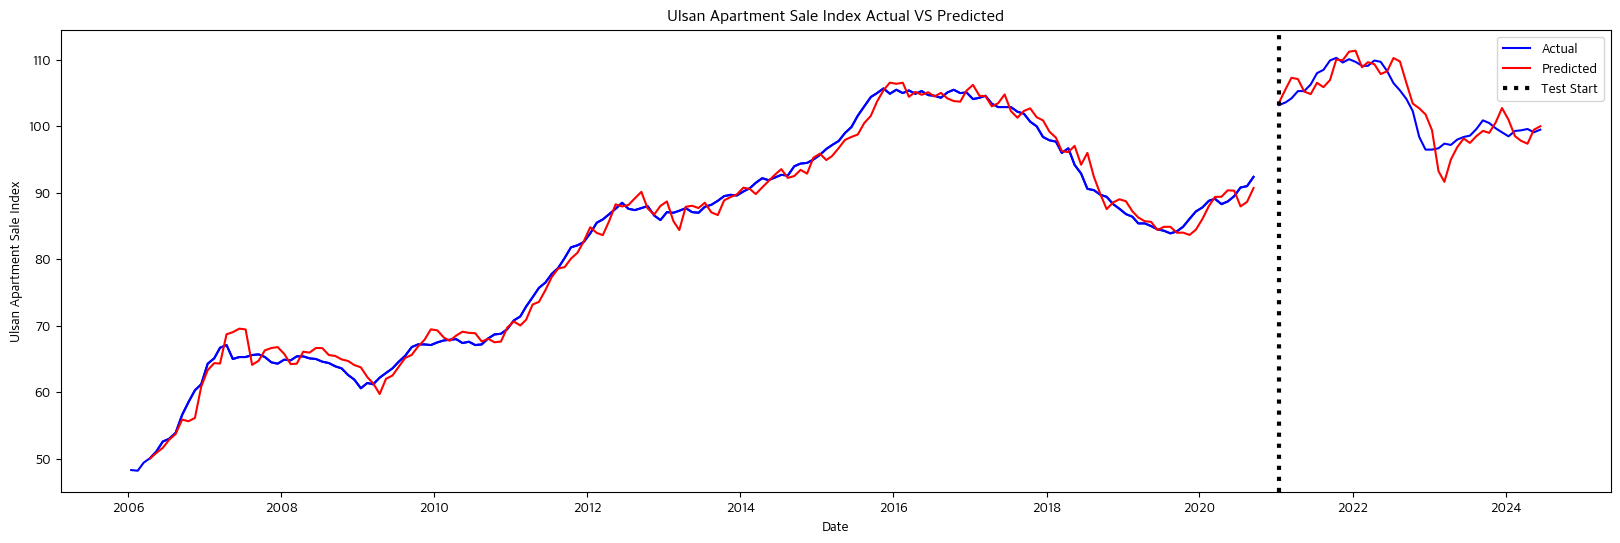

else


100%|██████████| 444/444 [00:08<00:00, 53.85it/s]


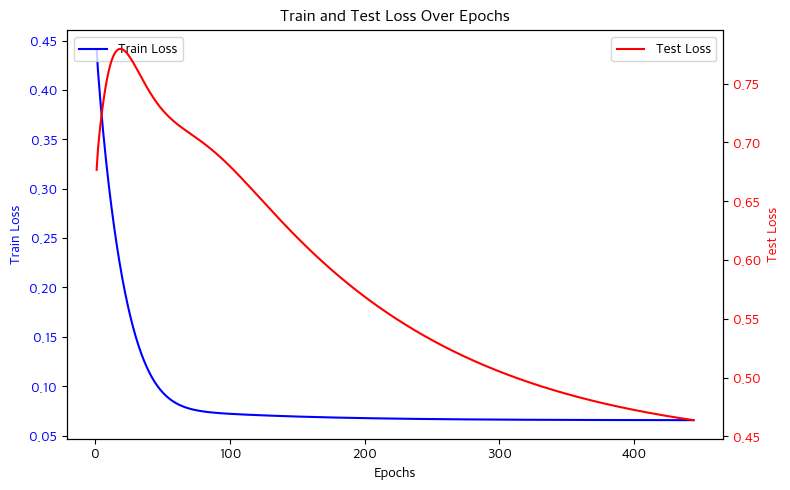

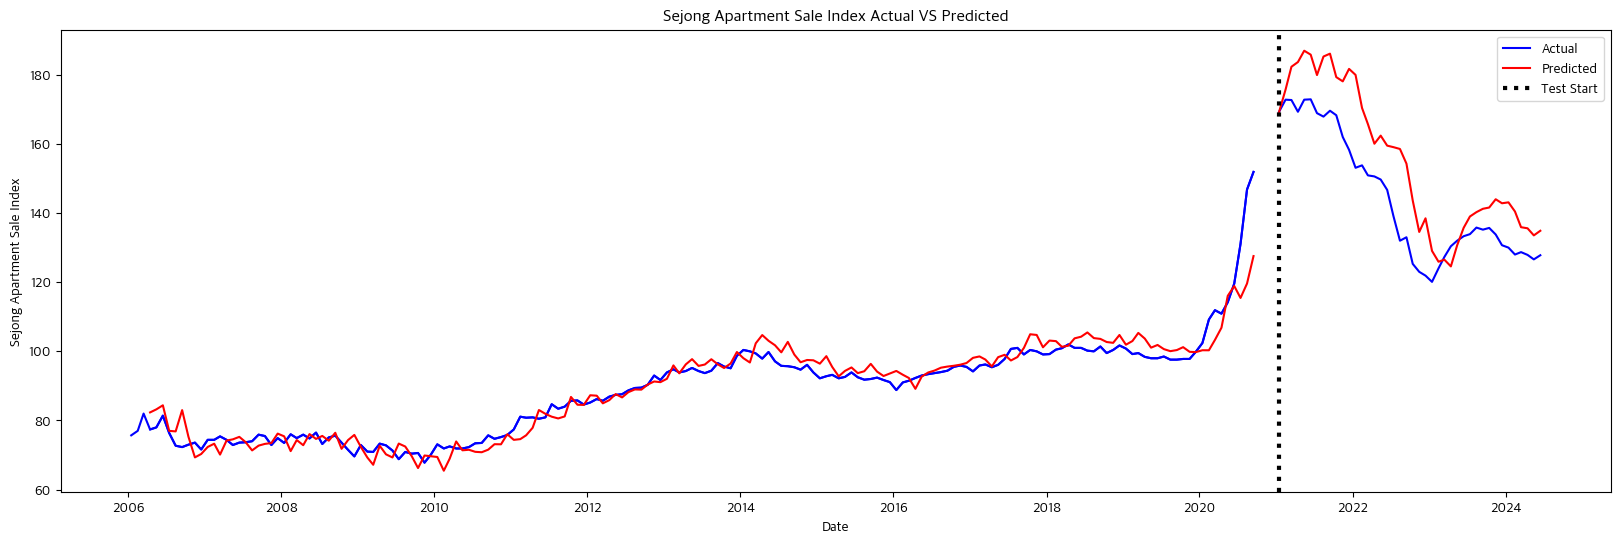

else


100%|██████████| 444/444 [00:11<00:00, 40.03it/s]


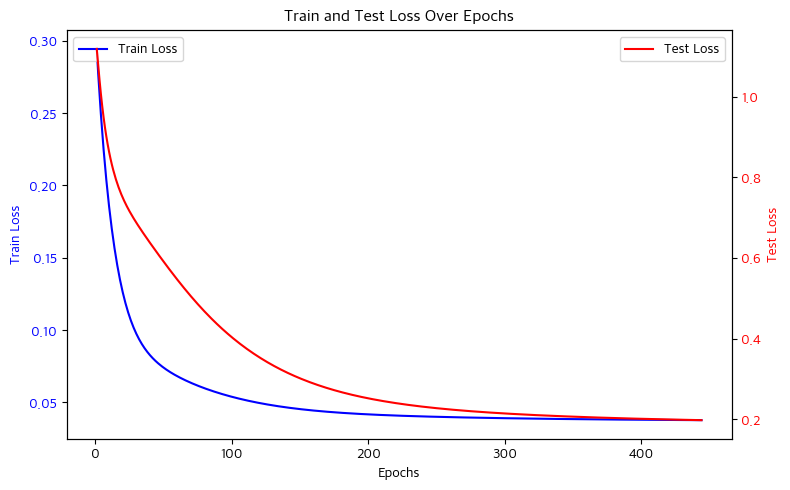

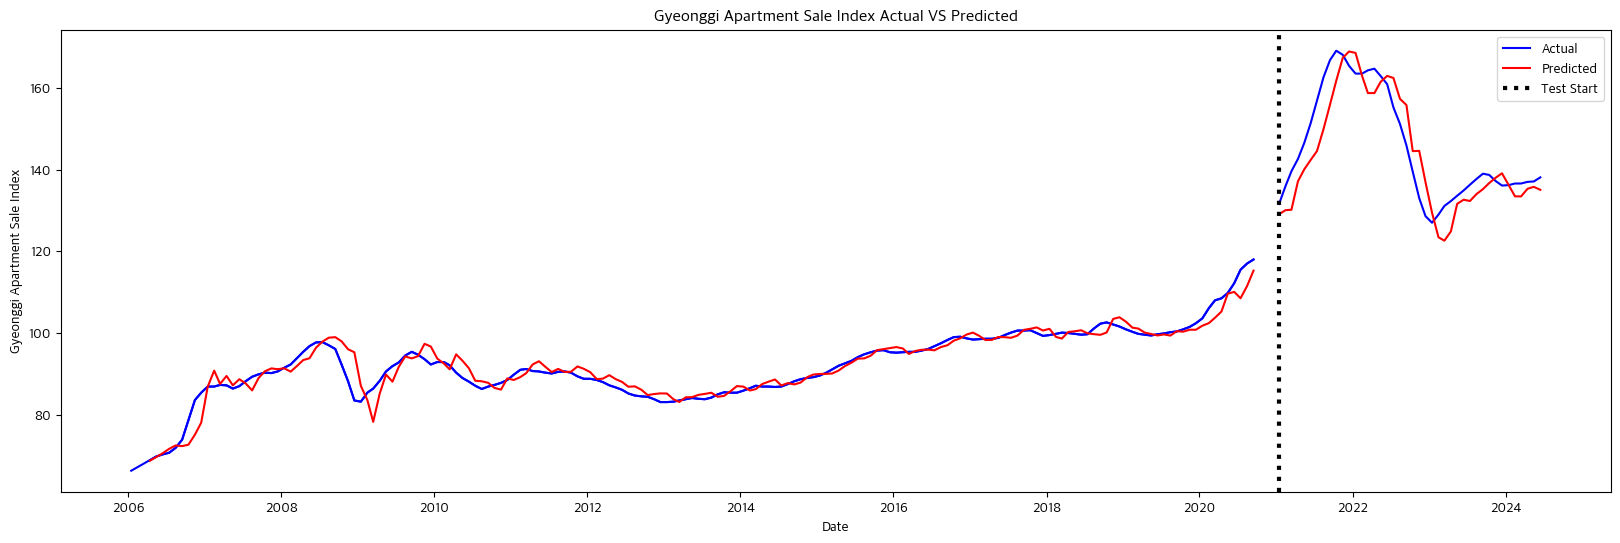

else


 99%|█████████▉| 441/444 [00:08<00:00, 54.07it/s]


Early stopping triggered.


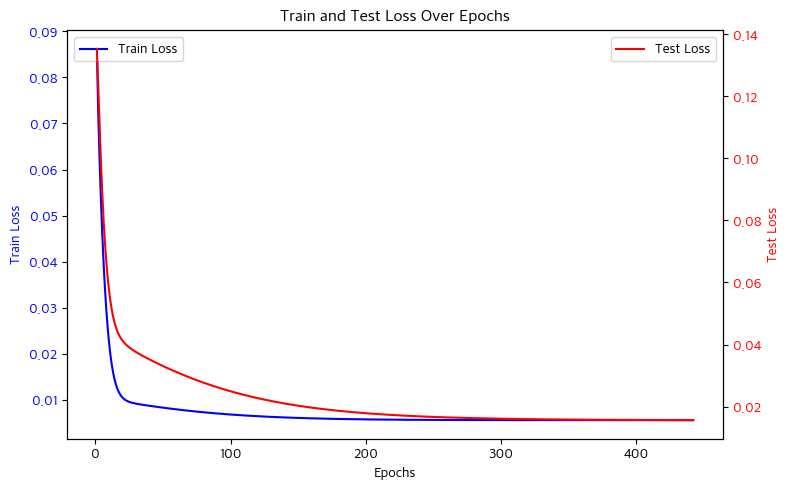

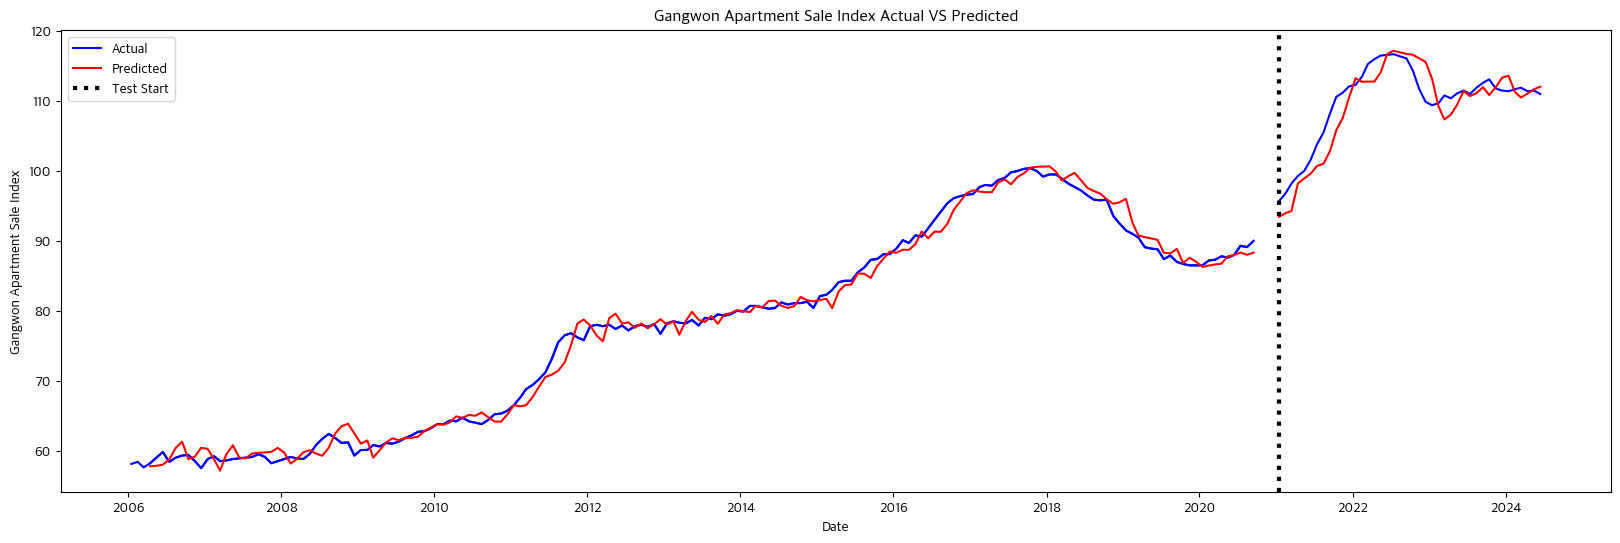

else


 96%|█████████▌| 424/442 [00:08<00:00, 50.66it/s]


Early stopping triggered.


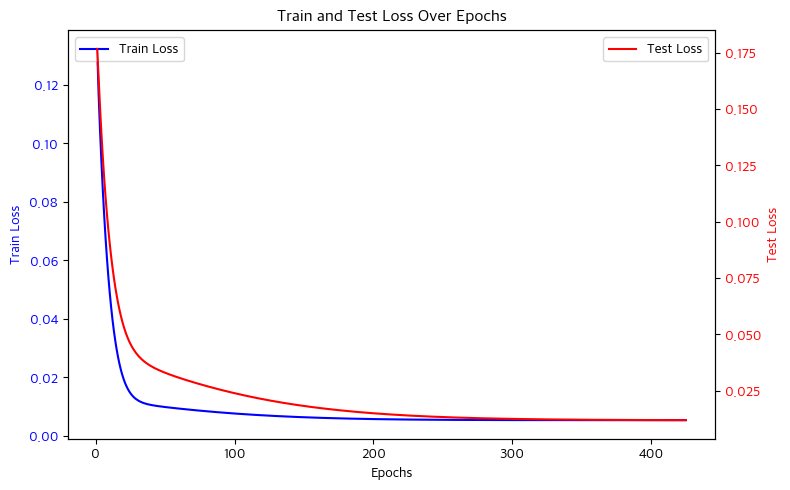

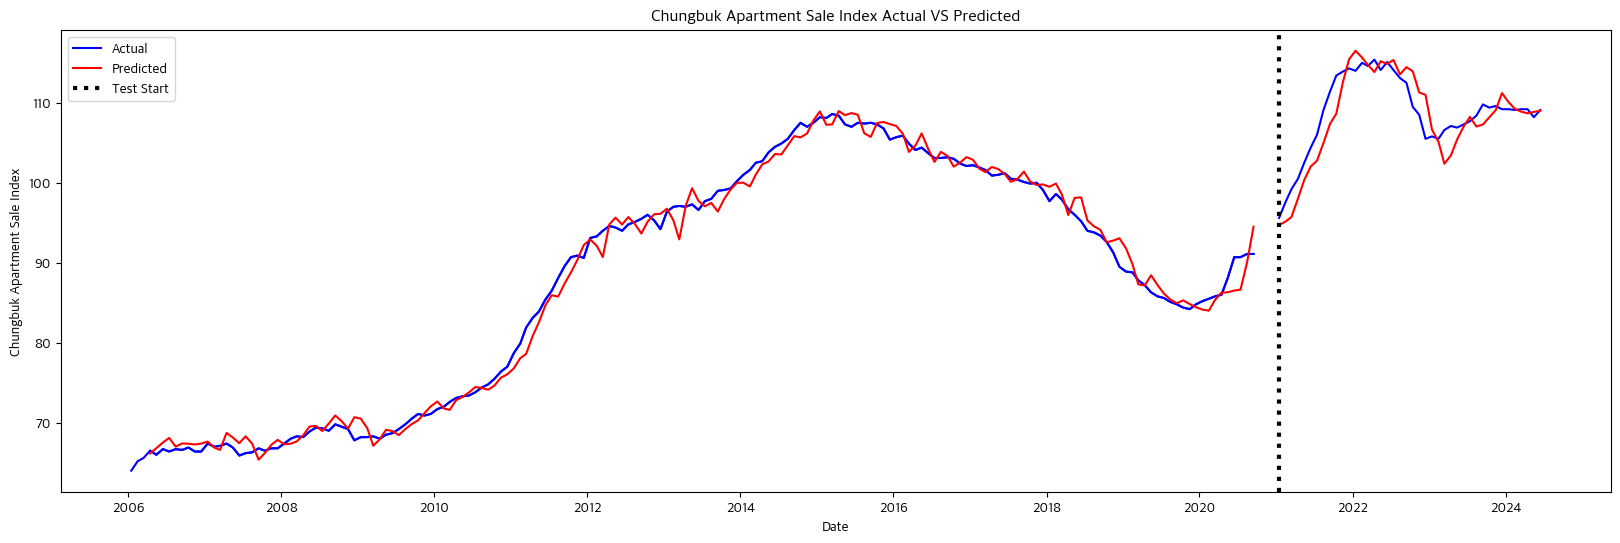

else


 98%|█████████▊| 418/425 [00:12<00:00, 32.73it/s]


Early stopping triggered.


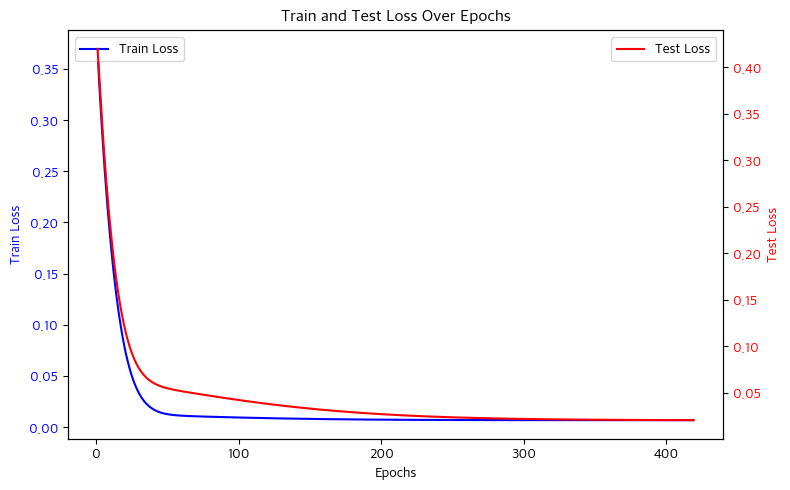

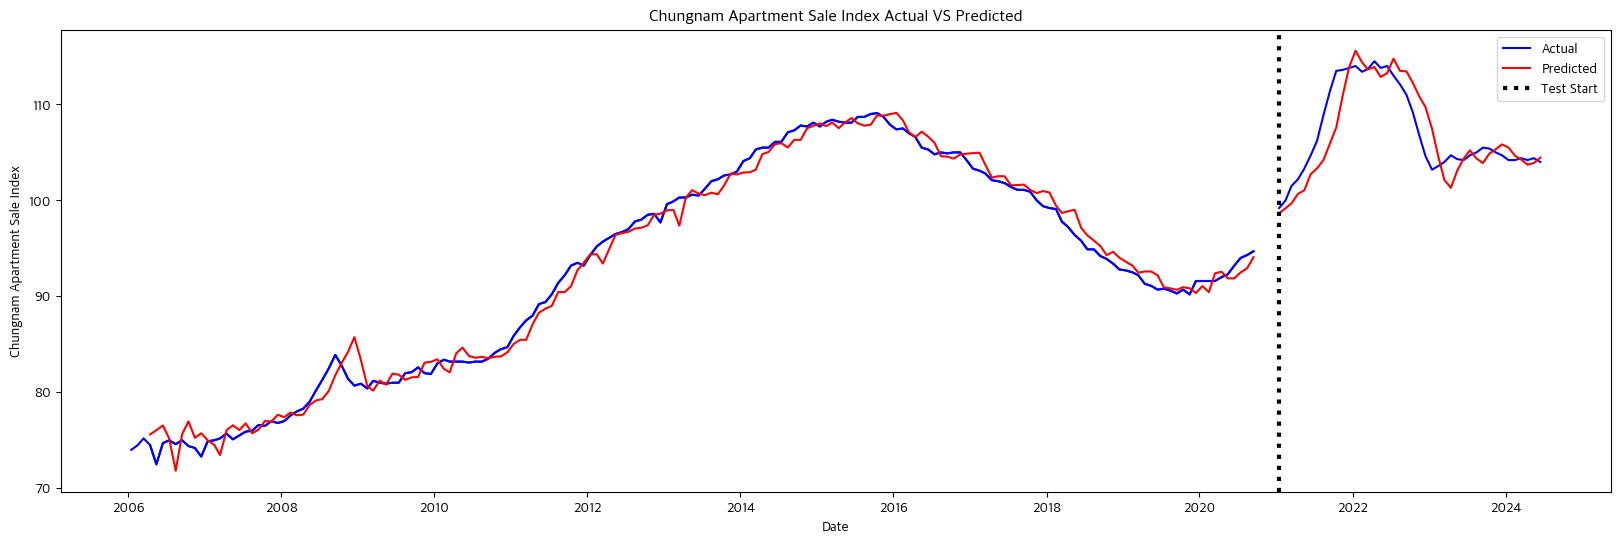

else


100%|██████████| 419/419 [00:09<00:00, 45.68it/s]


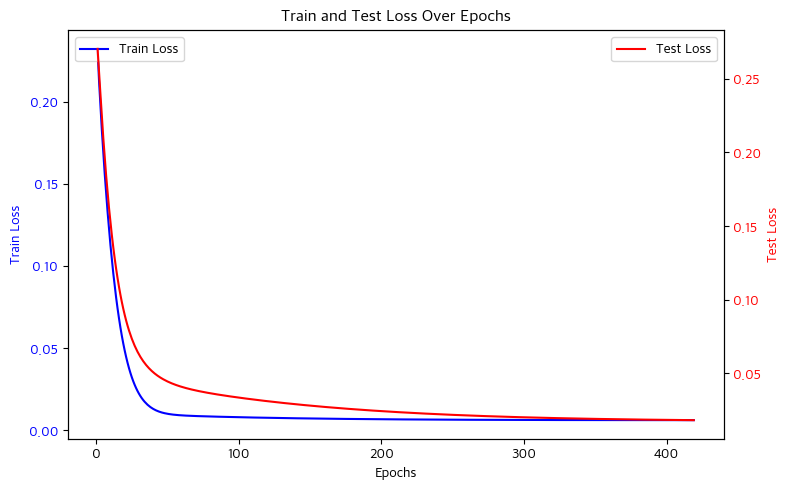

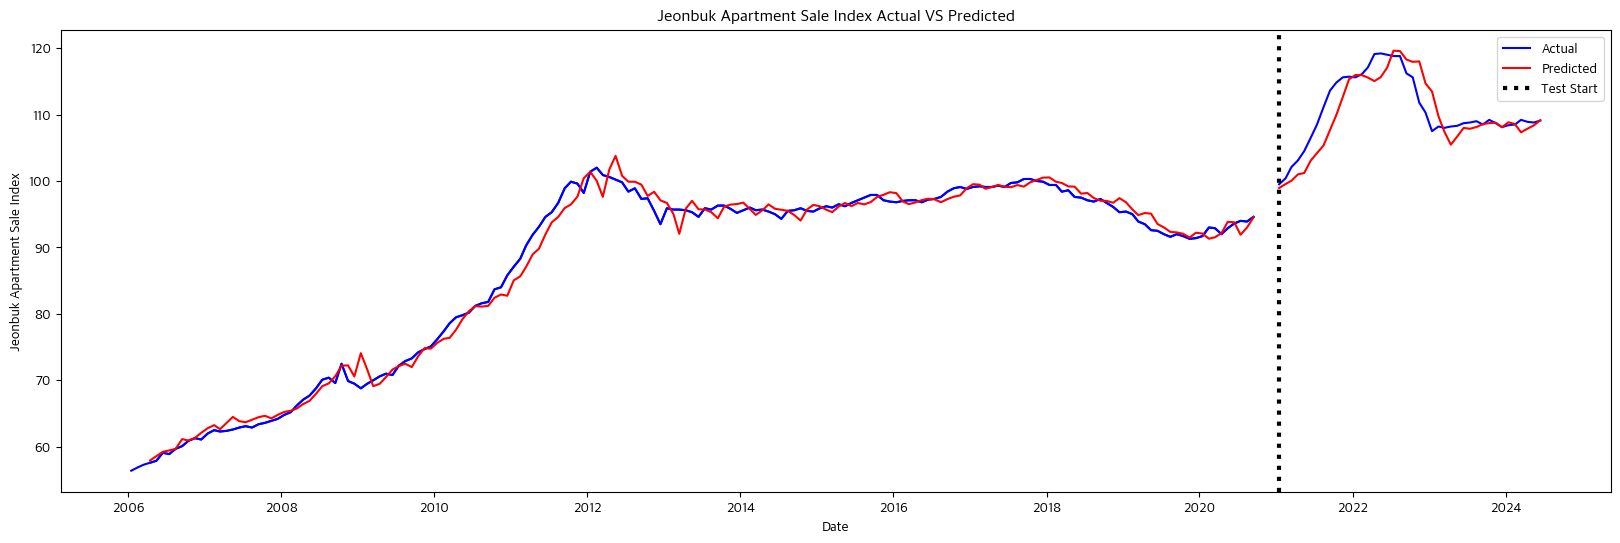

else


100%|██████████| 419/419 [00:08<00:00, 47.95it/s]


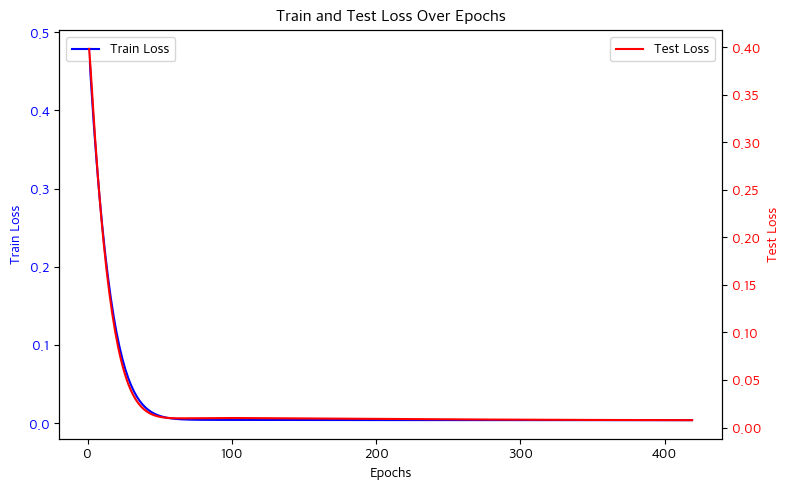

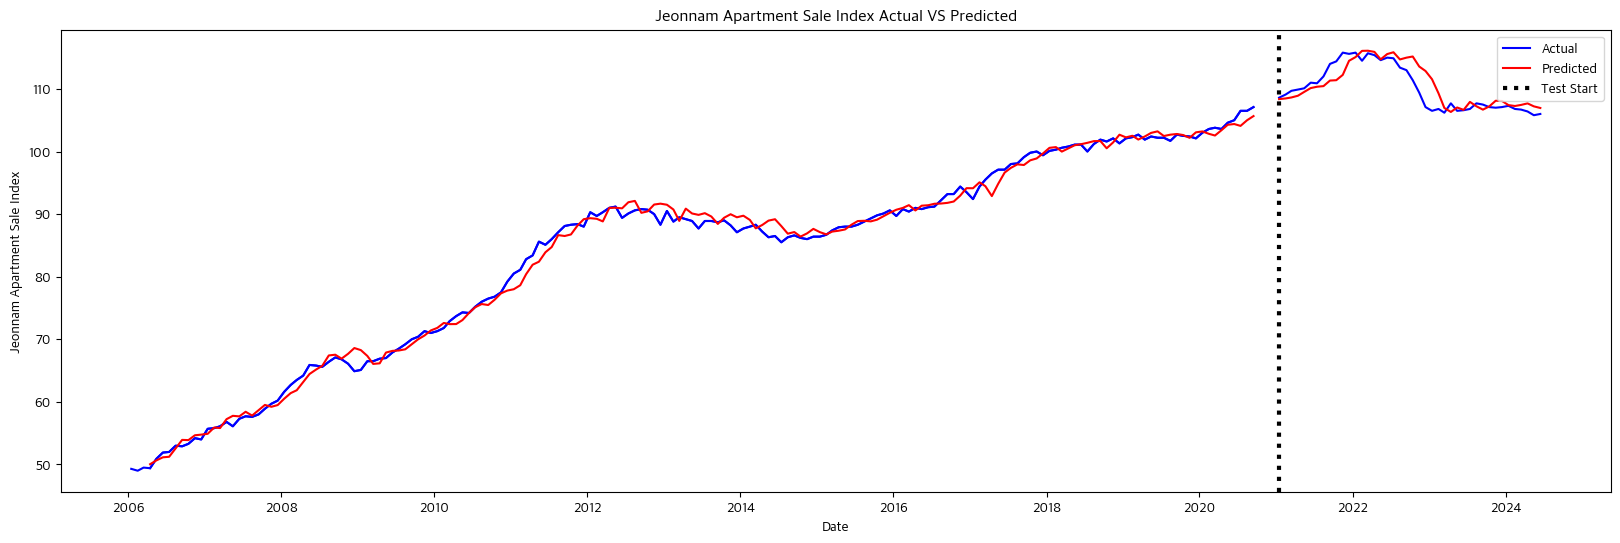

else


100%|██████████| 419/419 [00:08<00:00, 48.40it/s]


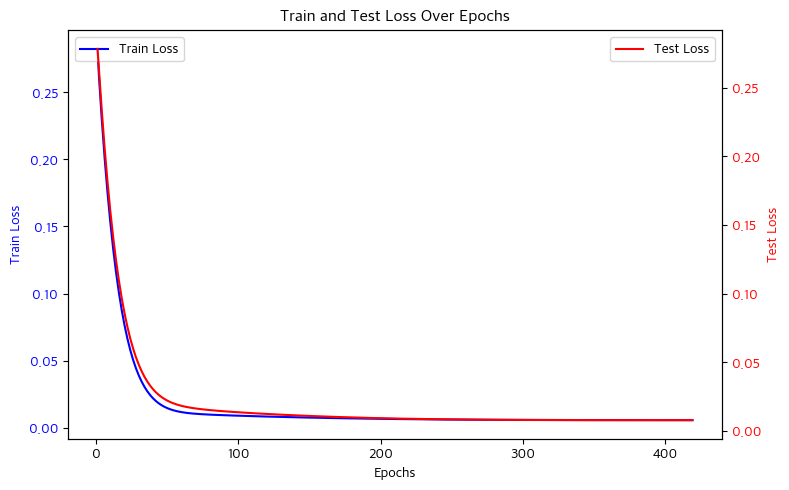

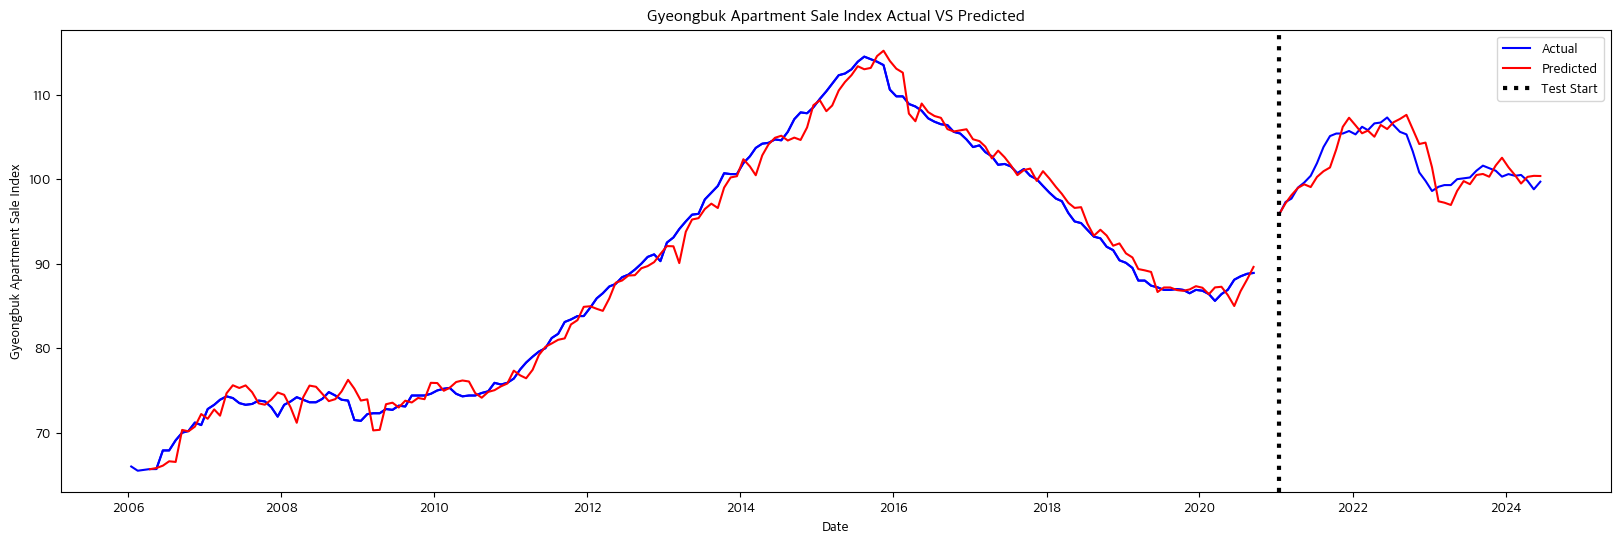

else


100%|██████████| 419/419 [00:08<00:00, 49.98it/s]


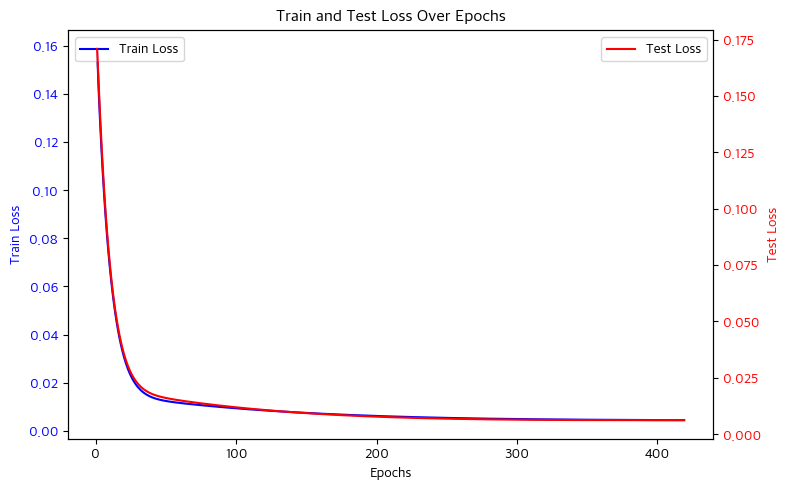

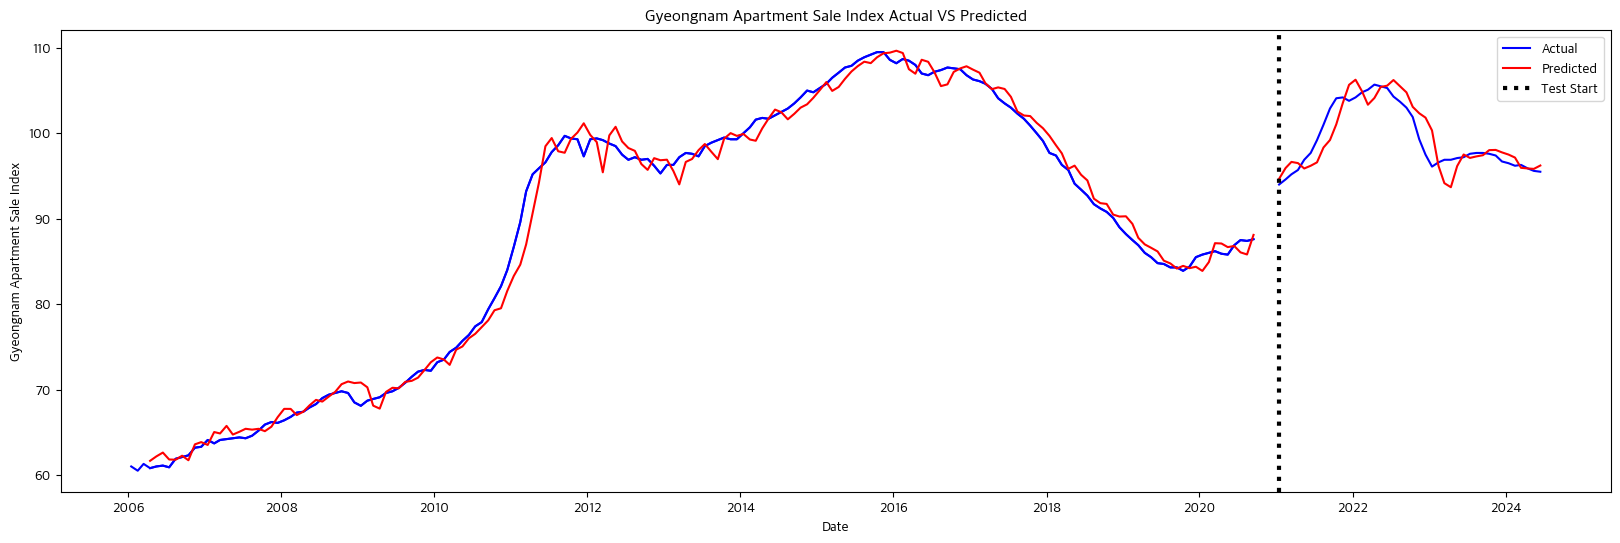

else


100%|██████████| 419/419 [00:08<00:00, 46.95it/s]


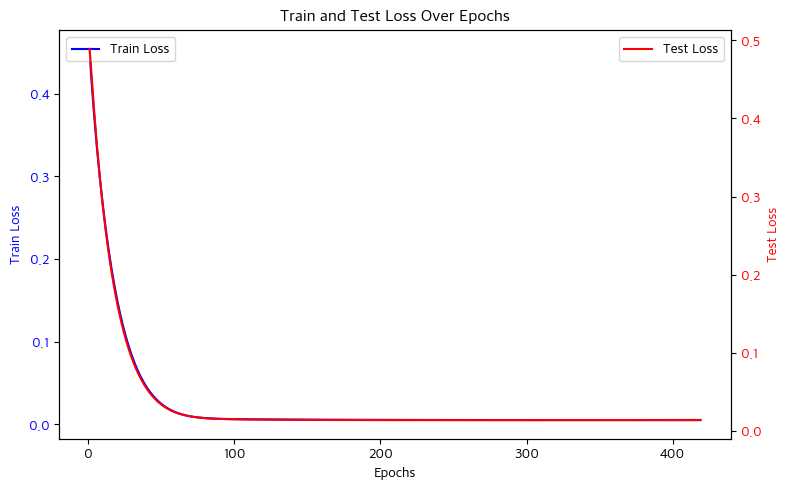

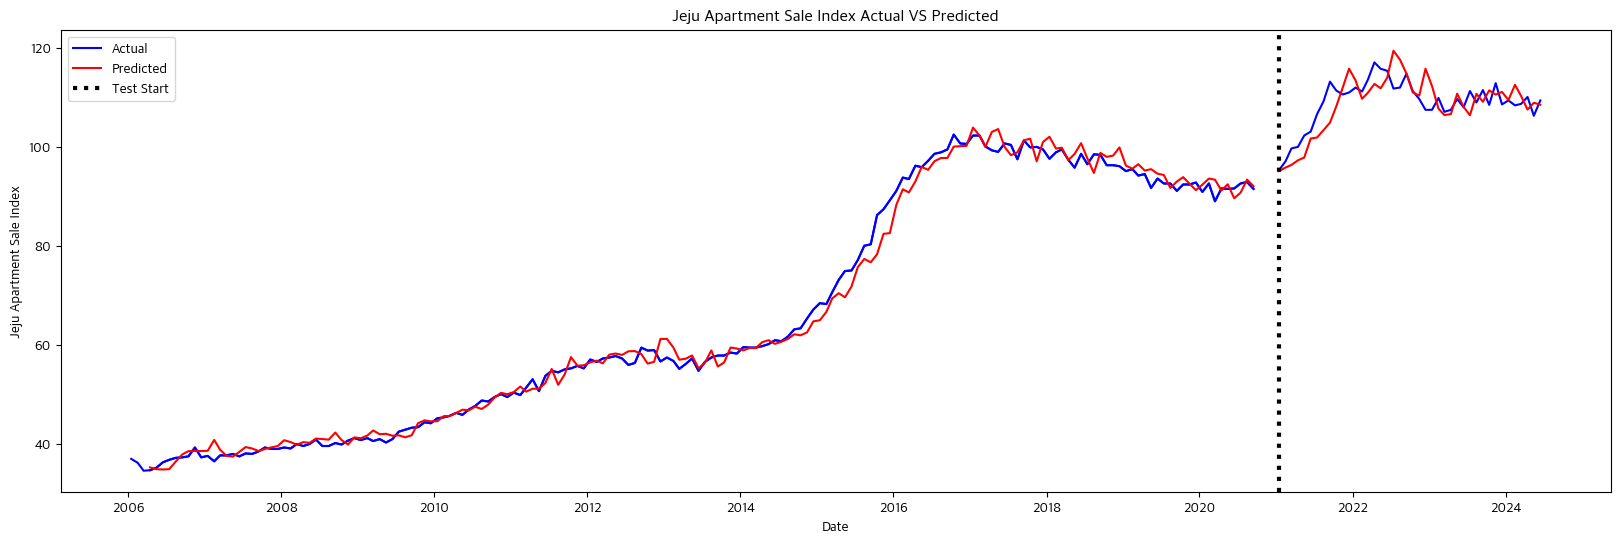

In [76]:
for i in range(len(target_column)):
    target_name = target_column[i] # Seoul
    targets = nf.columns[i] # Seoul_apartment_sale_price_index

    # Prepare Dataset
    train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, targets)
    columns_to_use = [targets]
    train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, targets, columns_to_use)
    # Prepare DataLoader 
    train_ds = Data(train_x, train_y)
    test_ds = Data(test_x, test_y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
    # Train the model 
    train_loss_list = [] # save the train loss
    test_loss_list = [] # save the test loss

    # Define the model
    DLinear_model = DLinear(configs=configs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
    max_loss = 999999999

    patience_counter = 0

    for epoch in tqdm(range(1, epoch+1)):
        loss_list = []
        DLinear_model.train()
        train_loss = 0.0 
        for batch_idx, (data, target) in enumerate(train_dl):
            optimizer.zero_grad()
            output = DLinear_model(data)
            loss = criterion(output, target.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
        train_loss = np.mean(loss_list) 
        train_loss_list.append(train_loss) 

        DLinear_model.eval()
        with torch.no_grad():
            test_loss_list_epoch = []
            for data, target in test_dl:
                output = DLinear_model(data)
                test_loss = criterion(output, target.unsqueeze(-1))
                test_loss_list_epoch.append(test_loss.item())
            
            test_loss = np.mean(test_loss_list_epoch)
            test_loss_list.append(test_loss)
        
        if train_loss < max_loss:
            torch.save(DLinear_model.state_dict(), f"./DLinear_{version}_{target_name}.pth")
            max_loss = train_loss
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = train_loss
            dlinear_best_test_loss = test_loss
        else:
            patience_counter += 1
            # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
    ### Plot Loss Result ###
    fig, ax1 = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(train_loss_list) + 1)
    ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel("Train Loss",color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc="upper left")
    # ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel("Test Loss",color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right") 
    # ax2.grid()
    plt.title('Train and Test Loss Over Epochs')
    fig.tight_layout()
    plt.show()
    
    # Load model and Evaluate
    DLinear_model.load_state_dict(torch.load(f"./DLinear_{version}_{target_name}.pth"))  # 최적 모델 로드
    DLinear_model.eval()
    te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
    tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
    
    # Calculate the prediction performance of test dataset
    real = test_targets
    pred = test_predictions
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    delta_y = np.diff(np.array(real).flatten())
    delta_y_hat = np.diff(np.array(pred).flatten())
    di = (np.sign(delta_y) == np.sign(delta_y_hat)).astype(int)
    DS = round(100 * np.sum(di) / len(di), 3)
    val =[target_name,rmse,r2,DS]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False) # save to file
    
    ### Plot Prediction Result ###
    plt.figure(figsize=(20,6))
    plt.title(f"{target_name} Apartment Sale Index Actual VS Predicted")
    plt.plot(train_df[date], train_df[targets], c='b',label="Actual")
    plt.plot(tr_dates, train_targets, c='b')
    plt.plot(tr_dates, train_predictions, c='r',label="Predicted")
    plt.plot(te_dates, test_targets, c='b')
    plt.plot(te_dates, test_predictions, c='r')
    plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.xlabel('Date')
    plt.ylabel(f"{target_name} Apartment Sale Index")
    plt.legend()
    plt.show()

### Evaluation

In [ ]:
# for i in range(len(target_column)):
#     target_name = target_column[i] # Seoul
#     targets = data.columns[i] # Seoul_apartment_sale_price_index
#     train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, targets)
#     columns_to_use = [date] + column + [targets]
#     train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, targets, columns_to_use)
#     test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, targets, columns_to_use)
#     train_ds = Data(train_x, train_y)
#     test_ds = Data(test_x, test_y)
#     train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
#     test_dl  = DataLoader(test_ds,  batch_size = batch_size, shuffle=False)
    
#     DLinear_model = DLinear(configs=configs)
#     DLinear_model.load_state_dict(torch.load('./DLinear_V3_{target_name}.pth').state_dict())  # 최적 모델 로드
#     DLinear_model.eval()
#     te_dates, test_predictions, test_targets = predict(DLinear_model, test_dl, test_date, std_, mean_)
#     tr_dates, train_predictions, train_targets = predict(DLinear_model, train_dl, train_date, std_, mean_)
#     plt.figure(figsize=(20,6))
#     plt.plot(train_df[date], train_df[targets], c='b')
#     plt.plot(tr_dates, train_targets, c='b')
#     plt.plot(tr_dates, train_predictions, c='r')
#     plt.plot(te_dates, test_targets, c='b')
#     plt.plot(te_dates, test_predictions, c='r')
#     plt.axvline(x=te_dates[0], color='black', linestyle=':', linewidth=3)
#     plt.show()